## BEVFormer  
#### A Spatiotemporal Transformer Baseline for Camera-based BEV Perception

---

> **BEVFormer: Learning Bird's-Eye-View Representation from Multi-Camera Images via Spatiotemporal Transformers**  
> *ECCV 2022*

- **Paper**: http://arxiv.org/abs/2203.17270  
- **Project Page**: https://opendrivelab.com/  
- **Slides (English)**: https://docs.google.com/presentation/d/1fTjuSKpj_-KRjUACr8o5TbKetAXlWrmpaorVvfCTZUA/edit  
- **Video Talk**: https://www.bilibili.com/video/BV12t4y1t7Lq  
- **BEV Perception Survey (PAMI)**: https://arxiv.org/abs/2209.05324  

---

### Overview

BEVFormer formulates camera-based 3D perception as a **query-based BEV representation learning problem**.

Instead of explicitly projecting image features into 3D space, the model reasons directly in BEV space through attention mechanisms, enabling:

- End-to-end camera-only BEV perception  
- Explicit modeling of temporal context  
- Transformer-based spatial–temporal feature aggregation  
- Strong performance on 3D detection and BEV-related tasks  

---

### ⚠️ Important Note

Please follow the **official BEVFormer GitHub repository README** for:

- Setting up the Python virtual environment  
- Installing the correct versions of `mmcv`, `mmdet3d`, and `detectron2`  
- Downloading and placing pretrained checkpoints  
- Preparing the nuScenes dataset and metadata files  

This notebook assumes that **the environment and checkpoints are prepared exactly as described in the original repository**.


## Part A — BEVFormer: Camera-based BEV Detection

This part introduces **BEVFormer**, a camera-only 3D object detection model that learns  
a unified **Bird’s-Eye-View (BEV) representation** using spatiotemporal transformers.

Goal: understand how BEVFormer is structured and how its main components interact.

---

### Part A.1 — Detector Wrapper (BEVFormer)

This module defines the **top-level detector**.


Key role:
- Acts as the main container that connects feature extraction, BEV modeling, and detection
- Manages training, inference, and temporal state

---

### Part A.2 — Image Feature Extraction

This module extracts visual features from **multi-camera images**.

We do:
- Process each camera image independently
- Extract multi-scale features using backbone + neck
- Optionally apply **GridMask** for data augmentation

Output:
- Multi-scale image features used as input to the BEV transformer

---

### Part A.3 — BEV Representation Learning

This module converts image features into **BEV space**.

We use:
- Learnable **BEV queries** arranged on a 2D grid
- Transformer encoder to aggregate multi-camera features

Key idea:
- BEV space is modeled implicitly via attention
- No explicit geometric projection is required

---

### Part A.4 — Temporal BEV Modeling

This module enables **video-based perception**.

We do:
- Cache BEV features from previous frames
- Build history BEV **without gradient computation** (memory-efficient)
- Reset BEV when a new scene starts
- Use ego-motion (CAN bus) to align BEV features

Goal:
- Stabilize detection across time

---

### Part A.5 — Detection Head (BEVFormerHead)

This module performs **3D object detection in BEV space**.

We use:
- DETR-style, query-based detection
- Learnable object queries
- Transformer decoder for iterative refinement

Outputs:
- 3D bounding boxes
- Classification scores

---

### Part A.6 — Training Pipeline

This part explains how all modules interact during training.

We:
1. Build history BEV from previous frames
2. Process the current frame
3. Predict 3D bounding boxes in BEV
4. Compute detection losses

Key benefit:
- Temporal context improves robustness and accuracy



In [ ]:
# ---------------------------------------------
# Copyright (c) OpenMMLab. All rights reserved.
# ---------------------------------------------
#  Modified by Zhiqi Li
# ---------------------------------------------

import torch
from mmcv.runner import force_fp32, auto_fp16
from mmdet.models import DETECTORS
from mmdet3d.core import bbox3d2result
from mmdet3d.models.detectors.mvx_two_stage import MVXTwoStageDetector
from projects.mmdet3d_plugin.models.utils.grid_mask import GridMask
import time
import copy
import numpy as np
import mmdet3d
from projects.mmdet3d_plugin.models.utils.bricks import run_time


@DETECTORS.register_module()
class BEVFormer(MVXTwoStageDetector):
    """BEVFormer.
    Args:
        video_test_mode (bool): Decide whether to use temporal information during inference.
    """

    def __init__(self,
                 use_grid_mask=False,
                 pts_voxel_layer=None,
                 pts_voxel_encoder=None,
                 pts_middle_encoder=None,
                 pts_fusion_layer=None,
                 img_backbone=None,
                 pts_backbone=None,
                 img_neck=None,
                 pts_neck=None,
                 pts_bbox_head=None,
                 img_roi_head=None,
                 img_rpn_head=None,
                 train_cfg=None,
                 test_cfg=None,
                 pretrained=None,
                 video_test_mode=False
                 ):

        super(BEVFormer,
              self).__init__(pts_voxel_layer, pts_voxel_encoder,
                             pts_middle_encoder, pts_fusion_layer,
                             img_backbone, pts_backbone, img_neck, pts_neck,
                             pts_bbox_head, img_roi_head, img_rpn_head,
                             train_cfg, test_cfg, pretrained)
        self.grid_mask = GridMask(
            True, True, rotate=1, offset=False, ratio=0.5, mode=1, prob=0.7)
        self.use_grid_mask = use_grid_mask
        self.fp16_enabled = False

        # temporal
        self.video_test_mode = video_test_mode
        self.prev_frame_info = {
            'prev_bev': None,
            'scene_token': None,
            'prev_pos': 0,
            'prev_angle': 0,
        }


    def extract_img_feat(self, img, img_metas, len_queue=None):
        """Extract features of images."""
        B = img.size(0)
        if img is not None:
            
            # input_shape = img.shape[-2:]
            # # update real input shape of each single img
            # for img_meta in img_metas:
            #     img_meta.update(input_shape=input_shape)

            if img.dim() == 5 and img.size(0) == 1:
                img.squeeze_()
            elif img.dim() == 5 and img.size(0) > 1:
                B, N, C, H, W = img.size()
                img = img.reshape(B * N, C, H, W)
            if self.use_grid_mask:
                img = self.grid_mask(img)

            img_feats = self.img_backbone(img)
            if isinstance(img_feats, dict):
                img_feats = list(img_feats.values())
        else:
            return None
        if self.with_img_neck:
            img_feats = self.img_neck(img_feats)

        img_feats_reshaped = []
        for img_feat in img_feats:
            BN, C, H, W = img_feat.size()
            if len_queue is not None:
                img_feats_reshaped.append(img_feat.view(int(B/len_queue), len_queue, int(BN / B), C, H, W))
            else:
                img_feats_reshaped.append(img_feat.view(B, int(BN / B), C, H, W))
        return img_feats_reshaped

    @auto_fp16(apply_to=('img'))
    def extract_feat(self, img, img_metas=None, len_queue=None):
        """Extract features from images and points."""

        img_feats = self.extract_img_feat(img, img_metas, len_queue=len_queue)
        
        return img_feats


    def forward_pts_train(self,
                          pts_feats,
                          gt_bboxes_3d,
                          gt_labels_3d,
                          img_metas,
                          gt_bboxes_ignore=None,
                          prev_bev=None):
        """Forward function'
        Args:
            pts_feats (list[torch.Tensor]): Features of point cloud branch
            gt_bboxes_3d (list[:obj:`BaseInstance3DBoxes`]): Ground truth
                boxes for each sample.
            gt_labels_3d (list[torch.Tensor]): Ground truth labels for
                boxes of each sampole
            img_metas (list[dict]): Meta information of samples.
            gt_bboxes_ignore (list[torch.Tensor], optional): Ground truth
                boxes to be ignored. Defaults to None.
            prev_bev (torch.Tensor, optional): BEV features of previous frame.
        Returns:
            dict: Losses of each branch.
        """

        outs = self.pts_bbox_head(
            pts_feats, img_metas, prev_bev)
        loss_inputs = [gt_bboxes_3d, gt_labels_3d, outs]
        losses = self.pts_bbox_head.loss(*loss_inputs, img_metas=img_metas)
        return losses

    def forward_dummy(self, img):
        dummy_metas = None
        return self.forward_test(img=img, img_metas=[[dummy_metas]])

    def forward(self, return_loss=True, **kwargs):
        """Calls either forward_train or forward_test depending on whether
        return_loss=True.
        Note this setting will change the expected inputs. When
        `return_loss=True`, img and img_metas are single-nested (i.e.
        torch.Tensor and list[dict]), and when `resturn_loss=False`, img and
        img_metas should be double nested (i.e.  list[torch.Tensor],
        list[list[dict]]), with the outer list indicating test time
        augmentations.
        """
        if return_loss:
            return self.forward_train(**kwargs)
        else:
            return self.forward_test(**kwargs)
    
    def obtain_history_bev(self, imgs_queue, img_metas_list):
        """Obtain history BEV features iteratively. To save GPU memory, gradients are not calculated.
        """
        self.eval()

        with torch.no_grad():
            prev_bev = None
            bs, len_queue, num_cams, C, H, W = imgs_queue.shape
            imgs_queue = imgs_queue.reshape(bs*len_queue, num_cams, C, H, W)
            img_feats_list = self.extract_feat(img=imgs_queue, len_queue=len_queue)
            for i in range(len_queue):
                img_metas = [each[i] for each in img_metas_list]
                if not img_metas[0]['prev_bev_exists']:
                    prev_bev = None
                # img_feats = self.extract_feat(img=img, img_metas=img_metas)
                img_feats = [each_scale[:, i] for each_scale in img_feats_list]
                prev_bev = self.pts_bbox_head(
                    img_feats, img_metas, prev_bev, only_bev=True)
            self.train()
            return prev_bev

    @auto_fp16(apply_to=('img', 'points'))
    def forward_train(self,
                      points=None,
                      img_metas=None,
                      gt_bboxes_3d=None,
                      gt_labels_3d=None,
                      gt_labels=None,
                      gt_bboxes=None,
                      img=None,
                      proposals=None,
                      gt_bboxes_ignore=None,
                      img_depth=None,
                      img_mask=None,
                      ):
        """Forward training function.
        Args:
            points (list[torch.Tensor], optional): Points of each sample.
                Defaults to None.
            img_metas (list[dict], optional): Meta information of each sample.
                Defaults to None.
            gt_bboxes_3d (list[:obj:`BaseInstance3DBoxes`], optional):
                Ground truth 3D boxes. Defaults to None.
            gt_labels_3d (list[torch.Tensor], optional): Ground truth labels
                of 3D boxes. Defaults to None.
            gt_labels (list[torch.Tensor], optional): Ground truth labels
                of 2D boxes in images. Defaults to None.
            gt_bboxes (list[torch.Tensor], optional): Ground truth 2D boxes in
                images. Defaults to None.
            img (torch.Tensor optional): Images of each sample with shape
                (N, C, H, W). Defaults to None.
            proposals ([list[torch.Tensor], optional): Predicted proposals
                used for training Fast RCNN. Defaults to None.
            gt_bboxes_ignore (list[torch.Tensor], optional): Ground truth
                2D boxes in images to be ignored. Defaults to None.
        Returns:
            dict: Losses of different branches.
        """
        
        len_queue = img.size(1)
        prev_img = img[:, :-1, ...]
        img = img[:, -1, ...]

        prev_img_metas = copy.deepcopy(img_metas)
        prev_bev = self.obtain_history_bev(prev_img, prev_img_metas)

        img_metas = [each[len_queue-1] for each in img_metas]
        if not img_metas[0]['prev_bev_exists']:
            prev_bev = None
        img_feats = self.extract_feat(img=img, img_metas=img_metas)
        losses = dict()
        losses_pts = self.forward_pts_train(img_feats, gt_bboxes_3d,
                                            gt_labels_3d, img_metas,
                                            gt_bboxes_ignore, prev_bev)

        losses.update(losses_pts)
        return losses

    def forward_test(self, img_metas, img=None, **kwargs):
        for var, name in [(img_metas, 'img_metas')]:
            if not isinstance(var, list):
                raise TypeError('{} must be a list, but got {}'.format(
                    name, type(var)))
        img = [img] if img is None else img

        if img_metas[0][0]['scene_token'] != self.prev_frame_info['scene_token']:
            # the first sample of each scene is truncated
            self.prev_frame_info['prev_bev'] = None
        # update idx
        self.prev_frame_info['scene_token'] = img_metas[0][0]['scene_token']

        # do not use temporal information
        if not self.video_test_mode:
            self.prev_frame_info['prev_bev'] = None

        # Get the delta of ego position and angle between two timestamps.
        tmp_pos = copy.deepcopy(img_metas[0][0]['can_bus'][:3])
        tmp_angle = copy.deepcopy(img_metas[0][0]['can_bus'][-1])
        if self.prev_frame_info['prev_bev'] is not None:
            img_metas[0][0]['can_bus'][:3] -= self.prev_frame_info['prev_pos']
            img_metas[0][0]['can_bus'][-1] -= self.prev_frame_info['prev_angle']
        else:
            img_metas[0][0]['can_bus'][-1] = 0
            img_metas[0][0]['can_bus'][:3] = 0

        new_prev_bev, bbox_results = self.simple_test(
            img_metas[0], img[0], prev_bev=self.prev_frame_info['prev_bev'], **kwargs)
        # During inference, we save the BEV features and ego motion of each timestamp.
        self.prev_frame_info['prev_pos'] = tmp_pos
        self.prev_frame_info['prev_angle'] = tmp_angle
        self.prev_frame_info['prev_bev'] = new_prev_bev
        return bbox_results

    def simple_test_pts(self, x, img_metas, prev_bev=None, rescale=False):
        """Test function"""
        outs = self.pts_bbox_head(x, img_metas, prev_bev=prev_bev)

        bbox_list = self.pts_bbox_head.get_bboxes(
            outs, img_metas, rescale=rescale)
        bbox_results = [
            bbox3d2result(bboxes, scores, labels)
            for bboxes, scores, labels in bbox_list
        ]
        return outs['bev_embed'], bbox_results

    def simple_test(self, img_metas, img=None, prev_bev=None, rescale=False):
        """Test function without augmentaiton."""
        img_feats = self.extract_feat(img=img, img_metas=img_metas)

        bbox_list = [dict() for i in range(len(img_metas))]
        new_prev_bev, bbox_pts = self.simple_test_pts(
            img_feats, img_metas, prev_bev, rescale=rescale)
        for result_dict, pts_bbox in zip(bbox_list, bbox_pts):
            result_dict['pts_bbox'] = pts_bbox
        return new_prev_bev, bbox_list


## BEVFormerHead — Query-based 3D Detection in BEV Space

This section explains the role and design of **BEVFormerHead**,  
the detection head that converts BEV features into final **3D object predictions**.

BEVFormerHead follows a **DETR-style, set-based detection paradigm**  
and operates fully in **Bird’s-Eye-View (BEV) space**.

Goal: understand how BEV features are decoded into 3D bounding boxes.

---

### Head Definition

BEVFormerHead is registered as a detection head in MMDetection and inherits from `DETRHead`.

Key characteristics:
- Set-based prediction (no anchors, no NMS)
- Transformer decoder for iterative refinement
- Designed specifically for BEV-based 3D detection

---

### Main Components

This head consists of the following core elements:

- **BEV Queries**  
  Learnable grid queries of size `(bev_h × bev_w)` representing spatial locations in BEV

- **Object Queries**  
  Learnable object-level queries used to predict individual 3D objects

- **Transformer Encoder–Decoder**  
  - Encoder aggregates multi-camera image features into BEV space  
  - Decoder refines object queries using BEV features

- **Prediction Branches**  
  - Classification branch for object categories  
  - Regression branch for 3D bounding box parameters

---


### Training Targets and Losses

Training follows the standard **DETR matching strategy**:

- Hungarian assignment between predictions and ground truth
- Classification loss for object categories
- L1 regression loss for 3D bounding box parameters
- Losses are computed for all decoder layers, with the final layer emphasized

This encourages stable and consistent predictions across decoding stages.

---

### Inference

During inference:

- Predicted boxes are decoded using the bbox coder
- Outputs are converted into standard MMDetection3D formats
- BEV features can optionally be reused for temporal inference

This design supports efficient and consistent 3D detection.

---

### Summary

- BEVFormerHead performs **query-based 3D detection in BEV space**
- Built on DETR-style transformer decoders
- Supports temporal BEV fusion
- Cleanly integrates with the MMDetection3D pipeline

This head is a key component enabling BEVFormer’s strong camera-only 3D detection performance.


In [ ]:
import copy
import torch
import torch.nn as nn

from mmcv.cnn import Linear, bias_init_with_prob
from mmcv.utils import TORCH_VERSION, digit_version
from mmdet.core import (multi_apply, multi_apply, reduce_mean)
from mmdet.models.utils.transformer import inverse_sigmoid
from mmdet.models import HEADS
from mmdet.models.dense_heads import DETRHead
from mmdet3d.core.bbox.coders import build_bbox_coder
from projects.mmdet3d_plugin.core.bbox.util import normalize_bbox
from mmcv.runner import force_fp32, auto_fp16


@HEADS.register_module()
class BEVFormerHead(DETRHead):
    """Head of Detr3D.
    Args:
        with_box_refine (bool): Whether to refine the reference points
            in the decoder. Defaults to False.
        as_two_stage (bool) : Whether to generate the proposal from
            the outputs of encoder.
        transformer (obj:`ConfigDict`): ConfigDict is used for building
            the Encoder and Decoder.
        bev_h, bev_w (int): spatial shape of BEV queries.
    """

    def __init__(self,
                 *args,
                 with_box_refine=False,
                 as_two_stage=False,
                 transformer=None,
                 bbox_coder=None,
                 num_cls_fcs=2,
                 code_weights=None,
                 bev_h=30,
                 bev_w=30,
                 **kwargs):

        self.bev_h = bev_h
        self.bev_w = bev_w
        self.fp16_enabled = False

        self.with_box_refine = with_box_refine
        self.as_two_stage = as_two_stage
        if self.as_two_stage:
            transformer['as_two_stage'] = self.as_two_stage
        if 'code_size' in kwargs:
            self.code_size = kwargs['code_size']
        else:
            self.code_size = 10
        if code_weights is not None:
            self.code_weights = code_weights
        else:
            self.code_weights = [1.0, 1.0, 1.0,
                                 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.2]

        self.bbox_coder = build_bbox_coder(bbox_coder)
        self.pc_range = self.bbox_coder.pc_range
        self.real_w = self.pc_range[3] - self.pc_range[0]
        self.real_h = self.pc_range[4] - self.pc_range[1]
        self.num_cls_fcs = num_cls_fcs - 1
        super(BEVFormerHead, self).__init__(
            *args, transformer=transformer, **kwargs)
        self.code_weights = nn.Parameter(torch.tensor(
            self.code_weights, requires_grad=False), requires_grad=False)

    def _init_layers(self):
        """Initialize classification branch and regression branch of head."""
        cls_branch = []
        for _ in range(self.num_reg_fcs):
            cls_branch.append(Linear(self.embed_dims, self.embed_dims))
            cls_branch.append(nn.LayerNorm(self.embed_dims))
            cls_branch.append(nn.ReLU(inplace=True))
        cls_branch.append(Linear(self.embed_dims, self.cls_out_channels))
        fc_cls = nn.Sequential(*cls_branch)

        reg_branch = []
        for _ in range(self.num_reg_fcs):
            reg_branch.append(Linear(self.embed_dims, self.embed_dims))
            reg_branch.append(nn.ReLU())
        reg_branch.append(Linear(self.embed_dims, self.code_size))
        reg_branch = nn.Sequential(*reg_branch)

        def _get_clones(module, N):
            return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

        # last reg_branch is used to generate proposal from
        # encode feature map when as_two_stage is True.
        num_pred = (self.transformer.decoder.num_layers + 1) if \
            self.as_two_stage else self.transformer.decoder.num_layers

        if self.with_box_refine:
            self.cls_branches = _get_clones(fc_cls, num_pred)
            self.reg_branches = _get_clones(reg_branch, num_pred)
        else:
            self.cls_branches = nn.ModuleList(
                [fc_cls for _ in range(num_pred)])
            self.reg_branches = nn.ModuleList(
                [reg_branch for _ in range(num_pred)])

        if not self.as_two_stage:
            self.bev_embedding = nn.Embedding(
                self.bev_h * self.bev_w, self.embed_dims)
            self.query_embedding = nn.Embedding(self.num_query,
                                                self.embed_dims * 2)

    def init_weights(self):
        """Initialize weights of the DeformDETR head."""
        self.transformer.init_weights()
        if self.loss_cls.use_sigmoid:
            bias_init = bias_init_with_prob(0.01)
            for m in self.cls_branches:
                nn.init.constant_(m[-1].bias, bias_init)

    @auto_fp16(apply_to=('mlvl_feats'))
    def forward(self, mlvl_feats, img_metas, prev_bev=None,  only_bev=False):
        """Forward function.
        Args:
            mlvl_feats (tuple[Tensor]): Features from the upstream
                network, each is a 5D-tensor with shape
                (B, N, C, H, W).
            prev_bev: previous bev featues
            only_bev: only compute BEV features with encoder. 
        Returns:
            all_cls_scores (Tensor): Outputs from the classification head, \
                shape [nb_dec, bs, num_query, cls_out_channels]. Note \
                cls_out_channels should includes background.
            all_bbox_preds (Tensor): Sigmoid outputs from the regression \
                head with normalized coordinate format (cx, cy, w, l, cz, h, theta, vx, vy). \
                Shape [nb_dec, bs, num_query, 9].
        """
        bs, num_cam, _, _, _ = mlvl_feats[0].shape
        dtype = mlvl_feats[0].dtype
        object_query_embeds = self.query_embedding.weight.to(dtype)
        bev_queries = self.bev_embedding.weight.to(dtype)

        bev_mask = torch.zeros((bs, self.bev_h, self.bev_w),
                               device=bev_queries.device).to(dtype)
        bev_pos = self.positional_encoding(bev_mask).to(dtype)

        if only_bev:  # only use encoder to obtain BEV features, TODO: refine the workaround
            return self.transformer.get_bev_features(
                mlvl_feats,
                bev_queries,
                self.bev_h,
                self.bev_w,
                grid_length=(self.real_h / self.bev_h,
                             self.real_w / self.bev_w),
                bev_pos=bev_pos,
                img_metas=img_metas,
                prev_bev=prev_bev,
            )
        else:
            outputs = self.transformer(
                mlvl_feats,
                bev_queries,
                object_query_embeds,
                self.bev_h,
                self.bev_w,
                grid_length=(self.real_h / self.bev_h,
                             self.real_w / self.bev_w),
                bev_pos=bev_pos,
                reg_branches=self.reg_branches if self.with_box_refine else None,  # noqa:E501
                cls_branches=self.cls_branches if self.as_two_stage else None,
                img_metas=img_metas,
                prev_bev=prev_bev
        )

        bev_embed, hs, init_reference, inter_references = outputs
        hs = hs.permute(0, 2, 1, 3)
        outputs_classes = []
        outputs_coords = []
        for lvl in range(hs.shape[0]):
            if lvl == 0:
                reference = init_reference
            else:
                reference = inter_references[lvl - 1]
            reference = inverse_sigmoid(reference)
            outputs_class = self.cls_branches[lvl](hs[lvl])
            tmp = self.reg_branches[lvl](hs[lvl])

            # TODO: check the shape of reference
            assert reference.shape[-1] == 3
            tmp[..., 0:2] += reference[..., 0:2]
            tmp[..., 0:2] = tmp[..., 0:2].sigmoid()
            tmp[..., 4:5] += reference[..., 2:3]
            tmp[..., 4:5] = tmp[..., 4:5].sigmoid()
            tmp[..., 0:1] = (tmp[..., 0:1] * (self.pc_range[3] -
                             self.pc_range[0]) + self.pc_range[0])
            tmp[..., 1:2] = (tmp[..., 1:2] * (self.pc_range[4] -
                             self.pc_range[1]) + self.pc_range[1])
            tmp[..., 4:5] = (tmp[..., 4:5] * (self.pc_range[5] -
                             self.pc_range[2]) + self.pc_range[2])

            # TODO: check if using sigmoid
            outputs_coord = tmp
            outputs_classes.append(outputs_class)
            outputs_coords.append(outputs_coord)

        outputs_classes = torch.stack(outputs_classes)
        outputs_coords = torch.stack(outputs_coords)

        outs = {
            'bev_embed': bev_embed,
            'all_cls_scores': outputs_classes,
            'all_bbox_preds': outputs_coords,
            'enc_cls_scores': None,
            'enc_bbox_preds': None,
        }

        return outs

    def _get_target_single(self,
                           cls_score,
                           bbox_pred,
                           gt_labels,
                           gt_bboxes,
                           gt_bboxes_ignore=None):
        """"Compute regression and classification targets for one image.
        Outputs from a single decoder layer of a single feature level are used.
        Args:
            cls_score (Tensor): Box score logits from a single decoder layer
                for one image. Shape [num_query, cls_out_channels].
            bbox_pred (Tensor): Sigmoid outputs from a single decoder layer
                for one image, with normalized coordinate (cx, cy, w, h) and
                shape [num_query, 4].
            gt_bboxes (Tensor): Ground truth bboxes for one image with
                shape (num_gts, 4) in [tl_x, tl_y, br_x, br_y] format.
            gt_labels (Tensor): Ground truth class indices for one image
                with shape (num_gts, ).
            gt_bboxes_ignore (Tensor, optional): Bounding boxes
                which can be ignored. Default None.
        Returns:
            tuple[Tensor]: a tuple containing the following for one image.
                - labels (Tensor): Labels of each image.
                - label_weights (Tensor]): Label weights of each image.
                - bbox_targets (Tensor): BBox targets of each image.
                - bbox_weights (Tensor): BBox weights of each image.
                - pos_inds (Tensor): Sampled positive indices for each image.
                - neg_inds (Tensor): Sampled negative indices for each image.
        """

        num_bboxes = bbox_pred.size(0)
        # assigner and sampler
        gt_c = gt_bboxes.shape[-1]

        assign_result = self.assigner.assign(bbox_pred, cls_score, gt_bboxes,
                                             gt_labels, gt_bboxes_ignore)

        sampling_result = self.sampler.sample(assign_result, bbox_pred,
                                              gt_bboxes)
        pos_inds = sampling_result.pos_inds
        neg_inds = sampling_result.neg_inds

        # label targets
        labels = gt_bboxes.new_full((num_bboxes,),
                                    self.num_classes,
                                    dtype=torch.long)
        labels[pos_inds] = gt_labels[sampling_result.pos_assigned_gt_inds]
        label_weights = gt_bboxes.new_ones(num_bboxes)

        # bbox targets
        bbox_targets = torch.zeros_like(bbox_pred)[..., :gt_c]
        bbox_weights = torch.zeros_like(bbox_pred)
        bbox_weights[pos_inds] = 1.0

        # DETR
        bbox_targets[pos_inds] = sampling_result.pos_gt_bboxes
        return (labels, label_weights, bbox_targets, bbox_weights,
                pos_inds, neg_inds)

    def get_targets(self,
                    cls_scores_list,
                    bbox_preds_list,
                    gt_bboxes_list,
                    gt_labels_list,
                    gt_bboxes_ignore_list=None):
        """"Compute regression and classification targets for a batch image.
        Outputs from a single decoder layer of a single feature level are used.
        Args:
            cls_scores_list (list[Tensor]): Box score logits from a single
                decoder layer for each image with shape [num_query,
                cls_out_channels].
            bbox_preds_list (list[Tensor]): Sigmoid outputs from a single
                decoder layer for each image, with normalized coordinate
                (cx, cy, w, h) and shape [num_query, 4].
            gt_bboxes_list (list[Tensor]): Ground truth bboxes for each image
                with shape (num_gts, 4) in [tl_x, tl_y, br_x, br_y] format.
            gt_labels_list (list[Tensor]): Ground truth class indices for each
                image with shape (num_gts, ).
            gt_bboxes_ignore_list (list[Tensor], optional): Bounding
                boxes which can be ignored for each image. Default None.
        Returns:
            tuple: a tuple containing the following targets.
                - labels_list (list[Tensor]): Labels for all images.
                - label_weights_list (list[Tensor]): Label weights for all \
                    images.
                - bbox_targets_list (list[Tensor]): BBox targets for all \
                    images.
                - bbox_weights_list (list[Tensor]): BBox weights for all \
                    images.
                - num_total_pos (int): Number of positive samples in all \
                    images.
                - num_total_neg (int): Number of negative samples in all \
                    images.
        """
        assert gt_bboxes_ignore_list is None, \
            'Only supports for gt_bboxes_ignore setting to None.'
        num_imgs = len(cls_scores_list)
        gt_bboxes_ignore_list = [
            gt_bboxes_ignore_list for _ in range(num_imgs)
        ]

        (labels_list, label_weights_list, bbox_targets_list,
         bbox_weights_list, pos_inds_list, neg_inds_list) = multi_apply(
            self._get_target_single, cls_scores_list, bbox_preds_list,
            gt_labels_list, gt_bboxes_list, gt_bboxes_ignore_list)
        num_total_pos = sum((inds.numel() for inds in pos_inds_list))
        num_total_neg = sum((inds.numel() for inds in neg_inds_list))
        return (labels_list, label_weights_list, bbox_targets_list,
                bbox_weights_list, num_total_pos, num_total_neg)

    def loss_single(self,
                    cls_scores,
                    bbox_preds,
                    gt_bboxes_list,
                    gt_labels_list,
                    gt_bboxes_ignore_list=None):
        """"Loss function for outputs from a single decoder layer of a single
        feature level.
        Args:
            cls_scores (Tensor): Box score logits from a single decoder layer
                for all images. Shape [bs, num_query, cls_out_channels].
            bbox_preds (Tensor): Sigmoid outputs from a single decoder layer
                for all images, with normalized coordinate (cx, cy, w, h) and
                shape [bs, num_query, 4].
            gt_bboxes_list (list[Tensor]): Ground truth bboxes for each image
                with shape (num_gts, 4) in [tl_x, tl_y, br_x, br_y] format.
            gt_labels_list (list[Tensor]): Ground truth class indices for each
                image with shape (num_gts, ).
            gt_bboxes_ignore_list (list[Tensor], optional): Bounding
                boxes which can be ignored for each image. Default None.
        Returns:
            dict[str, Tensor]: A dictionary of loss components for outputs from
                a single decoder layer.
        """
        num_imgs = cls_scores.size(0)
        cls_scores_list = [cls_scores[i] for i in range(num_imgs)]
        bbox_preds_list = [bbox_preds[i] for i in range(num_imgs)]
        cls_reg_targets = self.get_targets(cls_scores_list, bbox_preds_list,
                                           gt_bboxes_list, gt_labels_list,
                                           gt_bboxes_ignore_list)
        (labels_list, label_weights_list, bbox_targets_list, bbox_weights_list,
         num_total_pos, num_total_neg) = cls_reg_targets
        labels = torch.cat(labels_list, 0)
        label_weights = torch.cat(label_weights_list, 0)
        bbox_targets = torch.cat(bbox_targets_list, 0)
        bbox_weights = torch.cat(bbox_weights_list, 0)

        # classification loss
        cls_scores = cls_scores.reshape(-1, self.cls_out_channels)
        # construct weighted avg_factor to match with the official DETR repo
        cls_avg_factor = num_total_pos * 1.0 + \
            num_total_neg * self.bg_cls_weight
        if self.sync_cls_avg_factor:
            cls_avg_factor = reduce_mean(
                cls_scores.new_tensor([cls_avg_factor]))

        cls_avg_factor = max(cls_avg_factor, 1)
        loss_cls = self.loss_cls(
            cls_scores, labels, label_weights, avg_factor=cls_avg_factor)

        # Compute the average number of gt boxes accross all gpus, for
        # normalization purposes
        num_total_pos = loss_cls.new_tensor([num_total_pos])
        num_total_pos = torch.clamp(reduce_mean(num_total_pos), min=1).item()

        # regression L1 loss
        bbox_preds = bbox_preds.reshape(-1, bbox_preds.size(-1))
        normalized_bbox_targets = normalize_bbox(bbox_targets, self.pc_range)
        isnotnan = torch.isfinite(normalized_bbox_targets).all(dim=-1)
        bbox_weights = bbox_weights * self.code_weights

        loss_bbox = self.loss_bbox(
            bbox_preds[isnotnan, :10], normalized_bbox_targets[isnotnan,
                                                               :10], bbox_weights[isnotnan, :10],
            avg_factor=num_total_pos)
        if digit_version(TORCH_VERSION) >= digit_version('1.8'):
            loss_cls = torch.nan_to_num(loss_cls)
            loss_bbox = torch.nan_to_num(loss_bbox)
        return loss_cls, loss_bbox

    @force_fp32(apply_to=('preds_dicts'))
    def loss(self,
             gt_bboxes_list,
             gt_labels_list,
             preds_dicts,
             gt_bboxes_ignore=None,
             img_metas=None):
        """"Loss function.
        Args:

            gt_bboxes_list (list[Tensor]): Ground truth bboxes for each image
                with shape (num_gts, 4) in [tl_x, tl_y, br_x, br_y] format.
            gt_labels_list (list[Tensor]): Ground truth class indices for each
                image with shape (num_gts, ).
            preds_dicts:
                all_cls_scores (Tensor): Classification score of all
                    decoder layers, has shape
                    [nb_dec, bs, num_query, cls_out_channels].
                all_bbox_preds (Tensor): Sigmoid regression
                    outputs of all decode layers. Each is a 4D-tensor with
                    normalized coordinate format (cx, cy, w, h) and shape
                    [nb_dec, bs, num_query, 4].
                enc_cls_scores (Tensor): Classification scores of
                    points on encode feature map , has shape
                    (N, h*w, num_classes). Only be passed when as_two_stage is
                    True, otherwise is None.
                enc_bbox_preds (Tensor): Regression results of each points
                    on the encode feature map, has shape (N, h*w, 4). Only be
                    passed when as_two_stage is True, otherwise is None.
            gt_bboxes_ignore (list[Tensor], optional): Bounding boxes
                which can be ignored for each image. Default None.
        Returns:
            dict[str, Tensor]: A dictionary of loss components.
        """
        assert gt_bboxes_ignore is None, \
            f'{self.__class__.__name__} only supports ' \
            f'for gt_bboxes_ignore setting to None.'

        all_cls_scores = preds_dicts['all_cls_scores']
        all_bbox_preds = preds_dicts['all_bbox_preds']
        enc_cls_scores = preds_dicts['enc_cls_scores']
        enc_bbox_preds = preds_dicts['enc_bbox_preds']

        num_dec_layers = len(all_cls_scores)
        device = gt_labels_list[0].device

        gt_bboxes_list = [torch.cat(
            (gt_bboxes.gravity_center, gt_bboxes.tensor[:, 3:]),
            dim=1).to(device) for gt_bboxes in gt_bboxes_list]

        all_gt_bboxes_list = [gt_bboxes_list for _ in range(num_dec_layers)]
        all_gt_labels_list = [gt_labels_list for _ in range(num_dec_layers)]
        all_gt_bboxes_ignore_list = [
            gt_bboxes_ignore for _ in range(num_dec_layers)
        ]

        losses_cls, losses_bbox = multi_apply(
            self.loss_single, all_cls_scores, all_bbox_preds,
            all_gt_bboxes_list, all_gt_labels_list,
            all_gt_bboxes_ignore_list)

        loss_dict = dict()
        # loss of proposal generated from encode feature map.
        if enc_cls_scores is not None:
            binary_labels_list = [
                torch.zeros_like(gt_labels_list[i])
                for i in range(len(all_gt_labels_list))
            ]
            enc_loss_cls, enc_losses_bbox = \
                self.loss_single(enc_cls_scores, enc_bbox_preds,
                                 gt_bboxes_list, binary_labels_list, gt_bboxes_ignore)
            loss_dict['enc_loss_cls'] = enc_loss_cls
            loss_dict['enc_loss_bbox'] = enc_losses_bbox

        # loss from the last decoder layer
        loss_dict['loss_cls'] = losses_cls[-1]
        loss_dict['loss_bbox'] = losses_bbox[-1]

        # loss from other decoder layers
        num_dec_layer = 0
        for loss_cls_i, loss_bbox_i in zip(losses_cls[:-1],
                                           losses_bbox[:-1]):
            loss_dict[f'd{num_dec_layer}.loss_cls'] = loss_cls_i
            loss_dict[f'd{num_dec_layer}.loss_bbox'] = loss_bbox_i
            num_dec_layer += 1
        return loss_dict

    @force_fp32(apply_to=('preds_dicts'))
    def get_bboxes(self, preds_dicts, img_metas, rescale=False):
        """Generate bboxes from bbox head predictions.
        Args:
            preds_dicts (tuple[list[dict]]): Prediction results.
            img_metas (list[dict]): Point cloud and image's meta info.
        Returns:
            list[dict]: Decoded bbox, scores and labels after nms.
        """

        preds_dicts = self.bbox_coder.decode(preds_dicts)

        num_samples = len(preds_dicts)
        ret_list = []
        for i in range(num_samples):
            preds = preds_dicts[i]
            bboxes = preds['bboxes']

            bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 5] * 0.5

            code_size = bboxes.shape[-1]
            bboxes = img_metas[i]['box_type_3d'](bboxes, code_size)
            scores = preds['scores']
            labels = preds['labels']

            ret_list.append([bboxes, scores, labels])

        return ret_list


@HEADS.register_module()
class BEVFormerHead_GroupDETR(BEVFormerHead):
    def __init__(self,
                 *args,
                 group_detr=1,
                 **kwargs):
        self.group_detr = group_detr
        assert 'num_query' in kwargs
        kwargs['num_query'] = group_detr * kwargs['num_query']
        super().__init__(*args, **kwargs)

    def forward(self, mlvl_feats, img_metas, prev_bev=None,  only_bev=False):
        bs, num_cam, _, _, _ = mlvl_feats[0].shape
        dtype = mlvl_feats[0].dtype
        object_query_embeds = self.query_embedding.weight.to(dtype)
        if not self.training:  # NOTE: Only difference to bevformer head
            object_query_embeds = object_query_embeds[:self.num_query // self.group_detr]
        bev_queries = self.bev_embedding.weight.to(dtype)

        bev_mask = torch.zeros((bs, self.bev_h, self.bev_w),
                               device=bev_queries.device).to(dtype)
        bev_pos = self.positional_encoding(bev_mask).to(dtype)

        if only_bev:
            return self.transformer.get_bev_features(
                mlvl_feats,
                bev_queries,
                self.bev_h,
                self.bev_w,
                grid_length=(self.real_h / self.bev_h,
                             self.real_w / self.bev_w),
                bev_pos=bev_pos,
                img_metas=img_metas,
                prev_bev=prev_bev,
            )
        else:
            outputs = self.transformer(
                mlvl_feats,
                bev_queries,
                object_query_embeds,
                self.bev_h,
                self.bev_w,
                grid_length=(self.real_h / self.bev_h,
                             self.real_w / self.bev_w),
                bev_pos=bev_pos,
                reg_branches=self.reg_branches if self.with_box_refine else None,  # noqa:E501
                cls_branches=self.cls_branches if self.as_two_stage else None,
                img_metas=img_metas,
                prev_bev=prev_bev
        )

        bev_embed, hs, init_reference, inter_references = outputs
        hs = hs.permute(0, 2, 1, 3)
        outputs_classes = []
        outputs_coords = []
        for lvl in range(hs.shape[0]):
            if lvl == 0:
                reference = init_reference
            else:
                reference = inter_references[lvl - 1]
            reference = inverse_sigmoid(reference)
            outputs_class = self.cls_branches[lvl](hs[lvl])
            tmp = self.reg_branches[lvl](hs[lvl])
            assert reference.shape[-1] == 3
            tmp[..., 0:2] += reference[..., 0:2]
            tmp[..., 0:2] = tmp[..., 0:2].sigmoid()
            tmp[..., 4:5] += reference[..., 2:3]
            tmp[..., 4:5] = tmp[..., 4:5].sigmoid()
            tmp[..., 0:1] = (tmp[..., 0:1] * (self.pc_range[3] -
                             self.pc_range[0]) + self.pc_range[0])
            tmp[..., 1:2] = (tmp[..., 1:2] * (self.pc_range[4] -
                             self.pc_range[1]) + self.pc_range[1])
            tmp[..., 4:5] = (tmp[..., 4:5] * (self.pc_range[5] -
                             self.pc_range[2]) + self.pc_range[2])
            outputs_coord = tmp
            outputs_classes.append(outputs_class)
            outputs_coords.append(outputs_coord)

        outputs_classes = torch.stack(outputs_classes)
        outputs_coords = torch.stack(outputs_coords)

        outs = {
            'bev_embed': bev_embed,
            'all_cls_scores': outputs_classes,
            'all_bbox_preds': outputs_coords,
            'enc_cls_scores': None,
            'enc_bbox_preds': None,
        }

        return outs

    def loss(self,
             gt_bboxes_list,
             gt_labels_list,
             preds_dicts,
             gt_bboxes_ignore=None,
             img_metas=None):
        """"Loss function.
        Args:

            gt_bboxes_list (list[Tensor]): Ground truth bboxes for each image
                with shape (num_gts, 4) in [tl_x, tl_y, br_x, br_y] format.
            gt_labels_list (list[Tensor]): Ground truth class indices for each
                image with shape (num_gts, ).
            preds_dicts:
                all_cls_scores (Tensor): Classification score of all
                    decoder layers, has shape
                    [nb_dec, bs, num_query, cls_out_channels].
                all_bbox_preds (Tensor): Sigmoid regression
                    outputs of all decode layers. Each is a 4D-tensor with
                    normalized coordinate format (cx, cy, w, h) and shape
                    [nb_dec, bs, num_query, 4].
                enc_cls_scores (Tensor): Classification scores of
                    points on encode feature map , has shape
                    (N, h*w, num_classes). Only be passed when as_two_stage is
                    True, otherwise is None.
                enc_bbox_preds (Tensor): Regression results of each points
                    on the encode feature map, has shape (N, h*w, 4). Only be
                    passed when as_two_stage is True, otherwise is None.
            gt_bboxes_ignore (list[Tensor], optional): Bounding boxes
                which can be ignored for each image. Default None.
        Returns:
            dict[str, Tensor]: A dictionary of loss components.
        """
        assert gt_bboxes_ignore is None, \
            f'{self.__class__.__name__} only supports ' \
            f'for gt_bboxes_ignore setting to None.'

        all_cls_scores = preds_dicts['all_cls_scores']
        all_bbox_preds = preds_dicts['all_bbox_preds']
        enc_cls_scores = preds_dicts['enc_cls_scores']
        enc_bbox_preds = preds_dicts['enc_bbox_preds']
        assert enc_cls_scores is None and enc_bbox_preds is None 

        num_dec_layers = len(all_cls_scores)
        device = gt_labels_list[0].device

        gt_bboxes_list = [torch.cat(
            (gt_bboxes.gravity_center, gt_bboxes.tensor[:, 3:]),
            dim=1).to(device) for gt_bboxes in gt_bboxes_list]

        all_gt_bboxes_list = [gt_bboxes_list for _ in range(num_dec_layers)]
        all_gt_labels_list = [gt_labels_list for _ in range(num_dec_layers)]
        all_gt_bboxes_ignore_list = [
            gt_bboxes_ignore for _ in range(num_dec_layers)
        ]

        loss_dict = dict()
        loss_dict['loss_cls'] = 0
        loss_dict['loss_bbox'] = 0
        for num_dec_layer in range(all_cls_scores.shape[0] - 1):
            loss_dict[f'd{num_dec_layer}.loss_cls'] = 0
            loss_dict[f'd{num_dec_layer}.loss_bbox'] = 0
        num_query_per_group = self.num_query // self.group_detr
        for group_index in range(self.group_detr):
            group_query_start = group_index * num_query_per_group
            group_query_end = (group_index+1) * num_query_per_group
            group_cls_scores =  all_cls_scores[:, :,group_query_start:group_query_end, :]
            group_bbox_preds = all_bbox_preds[:, :,group_query_start:group_query_end, :]
            losses_cls, losses_bbox = multi_apply(
                self.loss_single, group_cls_scores, group_bbox_preds,
                all_gt_bboxes_list, all_gt_labels_list,
                all_gt_bboxes_ignore_list)
            loss_dict['loss_cls'] += losses_cls[-1] / self.group_detr
            loss_dict['loss_bbox'] += losses_bbox[-1] / self.group_detr
            # loss from other decoder layers
            num_dec_layer = 0
            for loss_cls_i, loss_bbox_i in zip(losses_cls[:-1], losses_bbox[:-1]):
                loss_dict[f'd{num_dec_layer}.loss_cls'] += loss_cls_i / self.group_detr
                loss_dict[f'd{num_dec_layer}.loss_bbox'] += loss_bbox_i / self.group_detr
                num_dec_layer += 1
        return loss_dict

## PerceptionTransformer — Building BEV Features with Spatiotemporal Attention

This section explains **PerceptionTransformer**, the core transformer module used in BEVFormer.

Its main job is to:
- aggregate **multi-camera image features** into a unified **BEV (Bird’s-Eye View) feature map**, and
- optionally fuse **temporal context** using the previous frame’s BEV (`prev_bev`).

---

### What This Module Contains

PerceptionTransformer is composed of two main blocks:

- **Encoder** (`self.encoder`)  
  Builds the BEV feature grid by attending to multi-view image features  
  (this is where spatial cross-attention + temporal fusion happen).

- **Decoder** (`self.decoder`)  
  Takes **object queries** and predicts objects by attending to the BEV features  
  (this is used by the detection head to output boxes/classes).

---

### Learnable Embeddings (What the Model Adds)

To help the model distinguish feature sources, it uses:

- **Level embeddings** (`level_embeds`)  
  One embedding per FPN level (multi-scale feature identity)

- **Camera embeddings** (`cams_embeds`)  
  One embedding per camera (multi-view identity)

- **Reference point head** (`reference_points`)  
  Predicts initial normalized reference points for object queries (3D in normalized coords)

- **CAN bus MLP** (`can_bus_mlp`)  
  Encodes ego-motion / vehicle state signals and injects them into BEV queries

---

### get_bev_features(): How BEV is Built

`get_bev_features()` is the key function that generates **BEV grid features**.

It performs these steps:

1. **Prepare BEV queries + positional encoding**  
   - `bev_queries`: learnable tokens for each BEV grid cell  
   - `bev_pos`: positional encoding over the BEV plane

2. **Compute ego-motion shift (translation compensation)**  

3. **Inject CAN bus features into BEV queries (optional)**  

4. **Flatten multi-camera multi-level image features**  

5. **Run the encoder**  

Output shape (conceptually):
- `bev_embed`: `(bs, bev_h*bev_w, embed_dims)`

---

### forward(): BEV + Object Query Decoding

`forward()` does two things:

1. **Build BEV features**
   - calls `get_bev_features(...)` → `bev_embed`

2. **Decode object queries**
   - runs the **decoder** where object queries attend to BEV features

Returns:
- `bev_embed`: BEV features (used as memory for decoding)
- `inter_states`: decoder hidden states per layer
- `init_reference_out`: initial reference points
- `inter_references_out`: refined reference points across decoder layers

---

### Summary

- **Encoder**: turns multi-camera multi-scale image features into a unified BEV grid  
  (+ temporal alignment via shift/rotation and optional prev_bev fusion)

- **Decoder**: uses object queries to read from BEV and produce object-specific features  
  (later turned into classes + 3D boxes by BEVFormerHead)

PerceptionTransformer is the module that makes BEVFormer **spatiotemporal** and **camera-only**.


In [ ]:
# ---------------------------------------------
# Copyright (c) OpenMMLab. All rights reserved.
# ---------------------------------------------
#  Modified by Zhiqi Li
# ---------------------------------------------

import numpy as np
import torch
import torch.nn as nn
from mmcv.cnn import xavier_init
from mmcv.cnn.bricks.transformer import build_transformer_layer_sequence
from mmcv.runner.base_module import BaseModule

from mmdet.models.utils.builder import TRANSFORMER
from torch.nn.init import normal_
from projects.mmdet3d_plugin.models.utils.visual import save_tensor
from mmcv.runner.base_module import BaseModule
from torchvision.transforms.functional import rotate
from .temporal_self_attention import TemporalSelfAttention
from .spatial_cross_attention import MSDeformableAttention3D
from .decoder import CustomMSDeformableAttention
from projects.mmdet3d_plugin.models.utils.bricks import run_time
from mmcv.runner import force_fp32, auto_fp16


@TRANSFORMER.register_module()
class PerceptionTransformer(BaseModule):
    """Implements the Detr3D transformer.
    Args:
        as_two_stage (bool): Generate query from encoder features.
            Default: False.
        num_feature_levels (int): Number of feature maps from FPN:
            Default: 4.
        two_stage_num_proposals (int): Number of proposals when set
            `as_two_stage` as True. Default: 300.
    """

    def __init__(self,
                 num_feature_levels=4,
                 num_cams=6,
                 two_stage_num_proposals=300,
                 encoder=None,
                 decoder=None,
                 embed_dims=256,
                 rotate_prev_bev=True,
                 use_shift=True,
                 use_can_bus=True,
                 can_bus_norm=True,
                 use_cams_embeds=True,
                 rotate_center=[100, 100],
                 **kwargs):
        super(PerceptionTransformer, self).__init__(**kwargs)
        self.encoder = build_transformer_layer_sequence(encoder)
        self.decoder = build_transformer_layer_sequence(decoder)
        self.embed_dims = embed_dims
        self.num_feature_levels = num_feature_levels
        self.num_cams = num_cams
        self.fp16_enabled = False

        self.rotate_prev_bev = rotate_prev_bev
        self.use_shift = use_shift
        self.use_can_bus = use_can_bus
        self.can_bus_norm = can_bus_norm
        self.use_cams_embeds = use_cams_embeds

        self.two_stage_num_proposals = two_stage_num_proposals
        self.init_layers()
        self.rotate_center = rotate_center

    def init_layers(self):
        """Initialize layers of the Detr3DTransformer."""
        self.level_embeds = nn.Parameter(torch.Tensor(
            self.num_feature_levels, self.embed_dims))
        self.cams_embeds = nn.Parameter(
            torch.Tensor(self.num_cams, self.embed_dims))
        self.reference_points = nn.Linear(self.embed_dims, 3)
        self.can_bus_mlp = nn.Sequential(
            nn.Linear(18, self.embed_dims // 2),
            nn.ReLU(inplace=True),
            nn.Linear(self.embed_dims // 2, self.embed_dims),
            nn.ReLU(inplace=True),
        )
        if self.can_bus_norm:
            self.can_bus_mlp.add_module('norm', nn.LayerNorm(self.embed_dims))

    def init_weights(self):
        """Initialize the transformer weights."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        for m in self.modules():
            if isinstance(m, MSDeformableAttention3D) or isinstance(m, TemporalSelfAttention) \
                    or isinstance(m, CustomMSDeformableAttention):
                try:
                    m.init_weight()
                except AttributeError:
                    m.init_weights()
        normal_(self.level_embeds)
        normal_(self.cams_embeds)
        xavier_init(self.reference_points, distribution='uniform', bias=0.)
        xavier_init(self.can_bus_mlp, distribution='uniform', bias=0.)

    @auto_fp16(apply_to=('mlvl_feats', 'bev_queries', 'prev_bev', 'bev_pos'))
    def get_bev_features(
            self,
            mlvl_feats,
            bev_queries,
            bev_h,
            bev_w,
            grid_length=[0.512, 0.512],
            bev_pos=None,
            prev_bev=None,
            **kwargs):
        """
        obtain bev features.
        """

        bs = mlvl_feats[0].size(0)
        bev_queries = bev_queries.unsqueeze(1).repeat(1, bs, 1)
        bev_pos = bev_pos.flatten(2).permute(2, 0, 1)

        # obtain rotation angle and shift with ego motion
        delta_x = np.array([each['can_bus'][0]
                           for each in kwargs['img_metas']])
        delta_y = np.array([each['can_bus'][1]
                           for each in kwargs['img_metas']])
        ego_angle = np.array(
            [each['can_bus'][-2] / np.pi * 180 for each in kwargs['img_metas']])
        grid_length_y = grid_length[0]
        grid_length_x = grid_length[1]
        translation_length = np.sqrt(delta_x ** 2 + delta_y ** 2)
        translation_angle = np.arctan2(delta_y, delta_x) / np.pi * 180
        bev_angle = ego_angle - translation_angle
        shift_y = translation_length * \
            np.cos(bev_angle / 180 * np.pi) / grid_length_y / bev_h
        shift_x = translation_length * \
            np.sin(bev_angle / 180 * np.pi) / grid_length_x / bev_w
        shift_y = shift_y * self.use_shift
        shift_x = shift_x * self.use_shift
        shift = bev_queries.new_tensor(
            [shift_x, shift_y]).permute(1, 0)  # xy, bs -> bs, xy

        if prev_bev is not None:
            if prev_bev.shape[1] == bev_h * bev_w:
                prev_bev = prev_bev.permute(1, 0, 2)
            if self.rotate_prev_bev:
                for i in range(bs):
                    # num_prev_bev = prev_bev.size(1)
                    rotation_angle = kwargs['img_metas'][i]['can_bus'][-1]
                    tmp_prev_bev = prev_bev[:, i].reshape(
                        bev_h, bev_w, -1).permute(2, 0, 1)
                    tmp_prev_bev = rotate(tmp_prev_bev, rotation_angle,
                                          center=self.rotate_center)
                    tmp_prev_bev = tmp_prev_bev.permute(1, 2, 0).reshape(
                        bev_h * bev_w, 1, -1)
                    prev_bev[:, i] = tmp_prev_bev[:, 0]

        # add can bus signals
        can_bus = bev_queries.new_tensor(
            [each['can_bus'] for each in kwargs['img_metas']])  # [:, :]
        can_bus = self.can_bus_mlp(can_bus)[None, :, :]
        bev_queries = bev_queries + can_bus * self.use_can_bus

        feat_flatten = []
        spatial_shapes = []
        for lvl, feat in enumerate(mlvl_feats):
            bs, num_cam, c, h, w = feat.shape
            spatial_shape = (h, w)
            feat = feat.flatten(3).permute(1, 0, 3, 2)
            if self.use_cams_embeds:
                feat = feat + self.cams_embeds[:, None, None, :].to(feat.dtype)
            feat = feat + self.level_embeds[None,
                                            None, lvl:lvl + 1, :].to(feat.dtype)
            spatial_shapes.append(spatial_shape)
            feat_flatten.append(feat)

        feat_flatten = torch.cat(feat_flatten, 2)
        spatial_shapes = torch.as_tensor(
            spatial_shapes, dtype=torch.long, device=bev_pos.device)
        level_start_index = torch.cat((spatial_shapes.new_zeros(
            (1,)), spatial_shapes.prod(1).cumsum(0)[:-1]))

        feat_flatten = feat_flatten.permute(
            0, 2, 1, 3)  # (num_cam, H*W, bs, embed_dims)

        bev_embed = self.encoder(
            bev_queries,
            feat_flatten,
            feat_flatten,
            bev_h=bev_h,
            bev_w=bev_w,
            bev_pos=bev_pos,
            spatial_shapes=spatial_shapes,
            level_start_index=level_start_index,
            prev_bev=prev_bev,
            shift=shift,
            **kwargs
        )

        return bev_embed

    @auto_fp16(apply_to=('mlvl_feats', 'bev_queries', 'object_query_embed', 'prev_bev', 'bev_pos'))
    def forward(self,
                mlvl_feats,
                bev_queries,
                object_query_embed,
                bev_h,
                bev_w,
                grid_length=[0.512, 0.512],
                bev_pos=None,
                reg_branches=None,
                cls_branches=None,
                prev_bev=None,
                **kwargs):
        """Forward function for `Detr3DTransformer`.
        Args:
            mlvl_feats (list(Tensor)): Input queries from
                different level. Each element has shape
                [bs, num_cams, embed_dims, h, w].
            bev_queries (Tensor): (bev_h*bev_w, c)
            bev_pos (Tensor): (bs, embed_dims, bev_h, bev_w)
            object_query_embed (Tensor): The query embedding for decoder,
                with shape [num_query, c].
            reg_branches (obj:`nn.ModuleList`): Regression heads for
                feature maps from each decoder layer. Only would
                be passed when `with_box_refine` is True. Default to None.
        Returns:
            tuple[Tensor]: results of decoder containing the following tensor.
                - bev_embed: BEV features
                - inter_states: Outputs from decoder. If
                    return_intermediate_dec is True output has shape \
                      (num_dec_layers, bs, num_query, embed_dims), else has \
                      shape (1, bs, num_query, embed_dims).
                - init_reference_out: The initial value of reference \
                    points, has shape (bs, num_queries, 4).
                - inter_references_out: The internal value of reference \
                    points in decoder, has shape \
                    (num_dec_layers, bs,num_query, embed_dims)
                - enc_outputs_class: The classification score of \
                    proposals generated from \
                    encoder's feature maps, has shape \
                    (batch, h*w, num_classes). \
                    Only would be returned when `as_two_stage` is True, \
                    otherwise None.
                - enc_outputs_coord_unact: The regression results \
                    generated from encoder's feature maps., has shape \
                    (batch, h*w, 4). Only would \
                    be returned when `as_two_stage` is True, \
                    otherwise None.
        """

        bev_embed = self.get_bev_features(
            mlvl_feats,
            bev_queries,
            bev_h,
            bev_w,
            grid_length=grid_length,
            bev_pos=bev_pos,
            prev_bev=prev_bev,
            **kwargs)  # bev_embed shape: bs, bev_h*bev_w, embed_dims

        bs = mlvl_feats[0].size(0)
        query_pos, query = torch.split(
            object_query_embed, self.embed_dims, dim=1)
        query_pos = query_pos.unsqueeze(0).expand(bs, -1, -1)
        query = query.unsqueeze(0).expand(bs, -1, -1)
        reference_points = self.reference_points(query_pos)
        reference_points = reference_points.sigmoid()
        init_reference_out = reference_points

        query = query.permute(1, 0, 2)
        query_pos = query_pos.permute(1, 0, 2)
        bev_embed = bev_embed.permute(1, 0, 2)

        inter_states, inter_references = self.decoder(
            query=query,
            key=None,
            value=bev_embed,
            query_pos=query_pos,
            reference_points=reference_points,
            reg_branches=reg_branches,
            cls_branches=cls_branches,
            spatial_shapes=torch.tensor([[bev_h, bev_w]], device=query.device),
            level_start_index=torch.tensor([0], device=query.device),
            **kwargs)

        inter_references_out = inter_references

        return bev_embed, inter_states, init_reference_out, inter_references_out


## BEVFormerEncoder — Spatiotemporal BEV Encoding (TSA + SCA)

This section summarizes the **BEVFormerEncoder** and its encoder layers used inside BEVFormer.

At a high level, the encoder builds **BEV features** by combining:
- **Temporal Self-Attention (TSA)**: fuses current BEV queries with **previous BEV** (`prev_bev`)
- **Spatial Cross-Attention (SCA)**: projects BEV queries into each camera view using **3D reference points** and gathers image features

---

### 1) BEVFormerEncoder (TransformerLayerSequence)

`BEVFormerEncoder` is a stack of encoder layers (`self.layers`) that repeatedly updates the BEV tokens.

---

### 2) Reference Points (2D vs 3D)

BEVFormer uses **two types of reference points**:

#### (a) 3D reference points (`dim='3d'`)
Used for **Spatial Cross-Attention**.

- A BEV cell (x, y) is expanded into multiple samples along height Z  
- Output shape (conceptually):  
  `ref_3d: (bs, bev_h*bev_w, num_points_in_pillar, 3)`

These points represent “pillars” in 3D space above each BEV location.

#### (b) 2D reference points (`dim='2d'`)
Used for **Temporal Self-Attention**.

- Reference points lie on the BEV plane only (x, y)
- Output shape (conceptually):  
  `ref_2d: (bs, bev_h*bev_w, 1, 2)`

---

### 3) point_sampling(): Project 3D BEV Points into Cameras

Outputs:
- `reference_points_cam`: per-camera projected coordinates
- `bev_mask`: valid/visible indicator used by attention to ignore invalid points

---

### 4) BEVFormerEncoder.forward(): How One Encoding Pass Works

Inputs:
- `bev_query`: BEV tokens `(num_bev, bs, C)`
- `key/value`: image features `(num_cam, num_tokens, bs, C)`
- `prev_bev`: optional previous BEV features
- `shift`: ego-motion-based BEV shift (translation compensation)

Output:
- final BEV tokens after all layers (or all intermediate outputs if enabled)

---

## BEVFormerLayer — One Encoder Layer (TSA → SCA → FFN)

`BEVFormerLayer` defines the **per-layer computation** via `operation_order`.

Expected operations (6 steps):
- `self_attn` → `norm` → `cross_attn` → `norm` → `ffn` → `norm`
(implementation checks that the order contains `self_attn`, `cross_attn`, `ffn`, `norm`)

### (a) Temporal Self-Attention (self_attn)

### (b) Spatial Cross-Attention (cross_attn)

### (c) Feed-Forward Network (ffn)

---

In [ ]:

# ---------------------------------------------
# Copyright (c) OpenMMLab. All rights reserved.
# ---------------------------------------------
#  Modified by Zhiqi Li
# ---------------------------------------------

import numpy as np
import torch
import copy
import warnings
from mmcv.cnn.bricks.registry import (ATTENTION,
                                      TRANSFORMER_LAYER,
                                      TRANSFORMER_LAYER_SEQUENCE)
from mmcv.cnn.bricks.transformer import TransformerLayerSequence
from mmcv.runner import force_fp32, auto_fp16
from mmcv.utils import TORCH_VERSION, digit_version
from mmcv.utils import ext_loader
from .custom_base_transformer_layer import MyCustomBaseTransformerLayer
ext_module = ext_loader.load_ext(
    '_ext', ['ms_deform_attn_backward', 'ms_deform_attn_forward'])


@TRANSFORMER_LAYER_SEQUENCE.register_module()
class BEVFormerEncoder(TransformerLayerSequence):

    """
    Attention with both self and cross
    Implements the decoder in DETR transformer.
    Args:
        return_intermediate (bool): Whether to return intermediate outputs.
        coder_norm_cfg (dict): Config of last normalization layer. Default：
            `LN`.
    """

    def __init__(self, *args, pc_range=None, num_points_in_pillar=4, return_intermediate=False, dataset_type='nuscenes',
                 **kwargs):

        super(BEVFormerEncoder, self).__init__(*args, **kwargs)
        self.return_intermediate = return_intermediate

        self.num_points_in_pillar = num_points_in_pillar
        self.pc_range = pc_range
        self.fp16_enabled = False

    @staticmethod
    def get_reference_points(H, W, Z=8, num_points_in_pillar=4, dim='3d', bs=1, device='cuda', dtype=torch.float):
        """Get the reference points used in SCA and TSA.
        Args:
            H, W: spatial shape of bev.
            Z: hight of pillar.
            D: sample D points uniformly from each pillar.
            device (obj:`device`): The device where
                reference_points should be.
        Returns:
            Tensor: reference points used in decoder, has \
                shape (bs, num_keys, num_levels, 2).
        """

        # reference points in 3D space, used in spatial cross-attention (SCA)
        if dim == '3d':
            zs = torch.linspace(0.5, Z - 0.5, num_points_in_pillar, dtype=dtype,
                                device=device).view(-1, 1, 1).expand(num_points_in_pillar, H, W) / Z
            xs = torch.linspace(0.5, W - 0.5, W, dtype=dtype,
                                device=device).view(1, 1, W).expand(num_points_in_pillar, H, W) / W
            ys = torch.linspace(0.5, H - 0.5, H, dtype=dtype,
                                device=device).view(1, H, 1).expand(num_points_in_pillar, H, W) / H
            ref_3d = torch.stack((xs, ys, zs), -1)
            ref_3d = ref_3d.permute(0, 3, 1, 2).flatten(2).permute(0, 2, 1)
            ref_3d = ref_3d[None].repeat(bs, 1, 1, 1)
            return ref_3d

        # reference points on 2D bev plane, used in temporal self-attention (TSA).
        elif dim == '2d':
            ref_y, ref_x = torch.meshgrid(
                torch.linspace(
                    0.5, H - 0.5, H, dtype=dtype, device=device),
                torch.linspace(
                    0.5, W - 0.5, W, dtype=dtype, device=device)
            )
            ref_y = ref_y.reshape(-1)[None] / H
            ref_x = ref_x.reshape(-1)[None] / W
            ref_2d = torch.stack((ref_x, ref_y), -1)
            ref_2d = ref_2d.repeat(bs, 1, 1).unsqueeze(2)
            return ref_2d

    # This function must use fp32!!!
    @force_fp32(apply_to=('reference_points', 'img_metas'))
    def point_sampling(self, reference_points, pc_range,  img_metas):
        # NOTE: close tf32 here.
        allow_tf32 = torch.backends.cuda.matmul.allow_tf32
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False

        lidar2img = []
        for img_meta in img_metas:
            lidar2img.append(img_meta['lidar2img'])
        lidar2img = np.asarray(lidar2img)
        lidar2img = reference_points.new_tensor(lidar2img)  # (B, N, 4, 4)
        reference_points = reference_points.clone()

        reference_points[..., 0:1] = reference_points[..., 0:1] * \
            (pc_range[3] - pc_range[0]) + pc_range[0]
        reference_points[..., 1:2] = reference_points[..., 1:2] * \
            (pc_range[4] - pc_range[1]) + pc_range[1]
        reference_points[..., 2:3] = reference_points[..., 2:3] * \
            (pc_range[5] - pc_range[2]) + pc_range[2]

        reference_points = torch.cat(
            (reference_points, torch.ones_like(reference_points[..., :1])), -1)

        reference_points = reference_points.permute(1, 0, 2, 3)
        D, B, num_query = reference_points.size()[:3]
        num_cam = lidar2img.size(1)

        reference_points = reference_points.view(
            D, B, 1, num_query, 4).repeat(1, 1, num_cam, 1, 1).unsqueeze(-1)

        lidar2img = lidar2img.view(
            1, B, num_cam, 1, 4, 4).repeat(D, 1, 1, num_query, 1, 1)

        reference_points_cam = torch.matmul(lidar2img.to(torch.float32),
                                            reference_points.to(torch.float32)).squeeze(-1)
        eps = 1e-5

        bev_mask = (reference_points_cam[..., 2:3] > eps)
        reference_points_cam = reference_points_cam[..., 0:2] / torch.maximum(
            reference_points_cam[..., 2:3], torch.ones_like(reference_points_cam[..., 2:3]) * eps)

        reference_points_cam[..., 0] /= img_metas[0]['img_shape'][0][1]
        reference_points_cam[..., 1] /= img_metas[0]['img_shape'][0][0]

        bev_mask = (bev_mask & (reference_points_cam[..., 1:2] > 0.0)
                    & (reference_points_cam[..., 1:2] < 1.0)
                    & (reference_points_cam[..., 0:1] < 1.0)
                    & (reference_points_cam[..., 0:1] > 0.0))
        if digit_version(TORCH_VERSION) >= digit_version('1.8'):
            bev_mask = torch.nan_to_num(bev_mask)
        else:
            bev_mask = bev_mask.new_tensor(
                np.nan_to_num(bev_mask.cpu().numpy()))

        reference_points_cam = reference_points_cam.permute(2, 1, 3, 0, 4)
        bev_mask = bev_mask.permute(2, 1, 3, 0, 4).squeeze(-1)

        torch.backends.cuda.matmul.allow_tf32 = allow_tf32
        torch.backends.cudnn.allow_tf32 = allow_tf32

        return reference_points_cam, bev_mask

    @auto_fp16()
    def forward(self,
                bev_query,
                key,
                value,
                *args,
                bev_h=None,
                bev_w=None,
                bev_pos=None,
                spatial_shapes=None,
                level_start_index=None,
                valid_ratios=None,
                prev_bev=None,
                shift=0.,
                **kwargs):
        """Forward function for `TransformerDecoder`.
        Args:
            bev_query (Tensor): Input BEV query with shape
                `(num_query, bs, embed_dims)`.
            key & value (Tensor): Input multi-cameta features with shape
                (num_cam, num_value, bs, embed_dims)
            reference_points (Tensor): The reference
                points of offset. has shape
                (bs, num_query, 4) when as_two_stage,
                otherwise has shape ((bs, num_query, 2).
            valid_ratios (Tensor): The radios of valid
                points on the feature map, has shape
                (bs, num_levels, 2)
        Returns:
            Tensor: Results with shape [1, num_query, bs, embed_dims] when
                return_intermediate is `False`, otherwise it has shape
                [num_layers, num_query, bs, embed_dims].
        """

        output = bev_query
        intermediate = []

        ref_3d = self.get_reference_points(
            bev_h, bev_w, self.pc_range[5]-self.pc_range[2], self.num_points_in_pillar, dim='3d', bs=bev_query.size(1),  device=bev_query.device, dtype=bev_query.dtype)
        ref_2d = self.get_reference_points(
            bev_h, bev_w, dim='2d', bs=bev_query.size(1), device=bev_query.device, dtype=bev_query.dtype)

        reference_points_cam, bev_mask = self.point_sampling(
            ref_3d, self.pc_range, kwargs['img_metas'])

        # bug: this code should be 'shift_ref_2d = ref_2d.clone()', we keep this bug for reproducing our results in paper.
        shift_ref_2d = ref_2d.clone()
        shift_ref_2d += shift[:, None, None, :]

        # (num_query, bs, embed_dims) -> (bs, num_query, embed_dims)
        bev_query = bev_query.permute(1, 0, 2)
        bev_pos = bev_pos.permute(1, 0, 2)
        bs, len_bev, num_bev_level, _ = ref_2d.shape
        if prev_bev is not None:
            prev_bev = prev_bev.permute(1, 0, 2)
            prev_bev = torch.stack(
                [prev_bev, bev_query], 1).reshape(bs*2, len_bev, -1)
            hybird_ref_2d = torch.stack([shift_ref_2d, ref_2d], 1).reshape(
                bs*2, len_bev, num_bev_level, 2)
        else:
            hybird_ref_2d = torch.stack([ref_2d, ref_2d], 1).reshape(
                bs*2, len_bev, num_bev_level, 2)

        for lid, layer in enumerate(self.layers):
            output = layer(
                bev_query,
                key,
                value,
                *args,
                bev_pos=bev_pos,
                ref_2d=hybird_ref_2d,
                ref_3d=ref_3d,
                bev_h=bev_h,
                bev_w=bev_w,
                spatial_shapes=spatial_shapes,
                level_start_index=level_start_index,
                reference_points_cam=reference_points_cam,
                bev_mask=bev_mask,
                prev_bev=prev_bev,
                **kwargs)

            bev_query = output
            if self.return_intermediate:
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output


@TRANSFORMER_LAYER.register_module()
class BEVFormerLayer(MyCustomBaseTransformerLayer):
    """Implements decoder layer in DETR transformer.
    Args:
        attn_cfgs (list[`mmcv.ConfigDict`] | list[dict] | dict )):
            Configs for self_attention or cross_attention, the order
            should be consistent with it in `operation_order`. If it is
            a dict, it would be expand to the number of attention in
            `operation_order`.
        feedforward_channels (int): The hidden dimension for FFNs.
        ffn_dropout (float): Probability of an element to be zeroed
            in ffn. Default 0.0.
        operation_order (tuple[str]): The execution order of operation
            in transformer. Such as ('self_attn', 'norm', 'ffn', 'norm').
            Default：None
        act_cfg (dict): The activation config for FFNs. Default: `LN`
        norm_cfg (dict): Config dict for normalization layer.
            Default: `LN`.
        ffn_num_fcs (int): The number of fully-connected layers in FFNs.
            Default：2.
    """

    def __init__(self,
                 attn_cfgs,
                 feedforward_channels,
                 ffn_dropout=0.0,
                 operation_order=None,
                 act_cfg=dict(type='ReLU', inplace=True),
                 norm_cfg=dict(type='LN'),
                 ffn_num_fcs=2,
                 **kwargs):
        super(BEVFormerLayer, self).__init__(
            attn_cfgs=attn_cfgs,
            feedforward_channels=feedforward_channels,
            ffn_dropout=ffn_dropout,
            operation_order=operation_order,
            act_cfg=act_cfg,
            norm_cfg=norm_cfg,
            ffn_num_fcs=ffn_num_fcs,
            **kwargs)
        self.fp16_enabled = False
        assert len(operation_order) == 6
        assert set(operation_order) == set(
            ['self_attn', 'norm', 'cross_attn', 'ffn'])

    def forward(self,
                query,
                key=None,
                value=None,
                bev_pos=None,
                query_pos=None,
                key_pos=None,
                attn_masks=None,
                query_key_padding_mask=None,
                key_padding_mask=None,
                ref_2d=None,
                ref_3d=None,
                bev_h=None,
                bev_w=None,
                reference_points_cam=None,
                mask=None,
                spatial_shapes=None,
                level_start_index=None,
                prev_bev=None,
                **kwargs):
        """Forward function for `TransformerDecoderLayer`.

        **kwargs contains some specific arguments of attentions.

        Args:
            query (Tensor): The input query with shape
                [num_queries, bs, embed_dims] if
                self.batch_first is False, else
                [bs, num_queries embed_dims].
            key (Tensor): The key tensor with shape [num_keys, bs,
                embed_dims] if self.batch_first is False, else
                [bs, num_keys, embed_dims] .
            value (Tensor): The value tensor with same shape as `key`.
            query_pos (Tensor): The positional encoding for `query`.
                Default: None.
            key_pos (Tensor): The positional encoding for `key`.
                Default: None.
            attn_masks (List[Tensor] | None): 2D Tensor used in
                calculation of corresponding attention. The length of
                it should equal to the number of `attention` in
                `operation_order`. Default: None.
            query_key_padding_mask (Tensor): ByteTensor for `query`, with
                shape [bs, num_queries]. Only used in `self_attn` layer.
                Defaults to None.
            key_padding_mask (Tensor): ByteTensor for `query`, with
                shape [bs, num_keys]. Default: None.

        Returns:
            Tensor: forwarded results with shape [num_queries, bs, embed_dims].
        """

        norm_index = 0
        attn_index = 0
        ffn_index = 0
        identity = query
        if attn_masks is None:
            attn_masks = [None for _ in range(self.num_attn)]
        elif isinstance(attn_masks, torch.Tensor):
            attn_masks = [
                copy.deepcopy(attn_masks) for _ in range(self.num_attn)
            ]
            warnings.warn(f'Use same attn_mask in all attentions in '
                          f'{self.__class__.__name__} ')
        else:
            assert len(attn_masks) == self.num_attn, f'The length of ' \
                                                     f'attn_masks {len(attn_masks)} must be equal ' \
                                                     f'to the number of attention in ' \
                f'operation_order {self.num_attn}'

        for layer in self.operation_order:
            # temporal self attention
            if layer == 'self_attn':

                query = self.attentions[attn_index](
                    query,
                    prev_bev,
                    prev_bev,
                    identity if self.pre_norm else None,
                    query_pos=bev_pos,
                    key_pos=bev_pos,
                    attn_mask=attn_masks[attn_index],
                    key_padding_mask=query_key_padding_mask,
                    reference_points=ref_2d,
                    spatial_shapes=torch.tensor(
                        [[bev_h, bev_w]], device=query.device),
                    level_start_index=torch.tensor([0], device=query.device),
                    **kwargs)
                attn_index += 1
                identity = query

            elif layer == 'norm':
                query = self.norms[norm_index](query)
                norm_index += 1

            # spaital cross attention
            elif layer == 'cross_attn':
                query = self.attentions[attn_index](
                    query,
                    key,
                    value,
                    identity if self.pre_norm else None,
                    query_pos=query_pos,
                    key_pos=key_pos,
                    reference_points=ref_3d,
                    reference_points_cam=reference_points_cam,
                    mask=mask,
                    attn_mask=attn_masks[attn_index],
                    key_padding_mask=key_padding_mask,
                    spatial_shapes=spatial_shapes,
                    level_start_index=level_start_index,
                    **kwargs)
                attn_index += 1
                identity = query

            elif layer == 'ffn':
                query = self.ffns[ffn_index](
                    query, identity if self.pre_norm else None)
                ffn_index += 1

        return query




from mmcv.cnn.bricks.transformer import build_feedforward_network, build_attention


@TRANSFORMER_LAYER.register_module()
class MM_BEVFormerLayer(MyCustomBaseTransformerLayer):
    """multi-modality fusion layer.
    """

    def __init__(self,
                 attn_cfgs,
                 feedforward_channels,
                 ffn_dropout=0.0,
                 operation_order=None,
                 act_cfg=dict(type='ReLU', inplace=True),
                 norm_cfg=dict(type='LN'),
                 ffn_num_fcs=2,
                 lidar_cross_attn_layer=None,
                 **kwargs):
        super(MM_BEVFormerLayer, self).__init__(
            attn_cfgs=attn_cfgs,
            feedforward_channels=feedforward_channels,
            ffn_dropout=ffn_dropout,
            operation_order=operation_order,
            act_cfg=act_cfg,
            norm_cfg=norm_cfg,
            ffn_num_fcs=ffn_num_fcs,
            **kwargs)
        self.fp16_enabled = False
        assert len(operation_order) == 6
        assert set(operation_order) == set(
            ['self_attn', 'norm', 'cross_attn', 'ffn'])
        self.cross_model_weights = torch.nn.Parameter(torch.tensor(0.5), requires_grad=True) 
        if lidar_cross_attn_layer:
            self.lidar_cross_attn_layer = build_attention(lidar_cross_attn_layer)
            # self.cross_model_weights+=1
        else:
            self.lidar_cross_attn_layer = None


    def forward(self,
                query,
                key=None,
                value=None,
                bev_pos=None,
                query_pos=None,
                key_pos=None,
                attn_masks=None,
                query_key_padding_mask=None,
                key_padding_mask=None,
                ref_2d=None,
                ref_3d=None,
                bev_h=None,
                bev_w=None,
                reference_points_cam=None,
                mask=None,
                spatial_shapes=None,
                level_start_index=None,
                prev_bev=None,
                debug=False,
                depth=None,
                depth_z=None,
                lidar_bev=None,
                radar_bev=None,
                **kwargs):
        """Forward function for `TransformerDecoderLayer`.

        **kwargs contains some specific arguments of attentions.

        Args:
            query (Tensor): The input query with shape
                [num_queries, bs, embed_dims] if
                self.batch_first is False, else
                [bs, num_queries embed_dims].
            key (Tensor): The key tensor with shape [num_keys, bs,
                embed_dims] if self.batch_first is False, else
                [bs, num_keys, embed_dims] .
            value (Tensor): The value tensor with same shape as `key`.
            query_pos (Tensor): The positional encoding for `query`.
                Default: None.
            key_pos (Tensor): The positional encoding for `key`.
                Default: None.
            attn_masks (List[Tensor] | None): 2D Tensor used in
                calculation of corresponding attention. The length of
                it should equal to the number of `attention` in
                `operation_order`. Default: None.
            query_key_padding_mask (Tensor): ByteTensor for `query`, with
                shape [bs, num_queries]. Only used in `self_attn` layer.
                Defaults to None.
            key_padding_mask (Tensor): ByteTensor for `query`, with
                shape [bs, num_keys]. Default: None.

        Returns:
            Tensor: forwarded results with shape [num_queries, bs, embed_dims].
        """

        norm_index = 0
        attn_index = 0
        ffn_index = 0
        identity = query
        if attn_masks is None:
            attn_masks = [None for _ in range(self.num_attn)]
        elif isinstance(attn_masks, torch.Tensor):
            attn_masks = [
                copy.deepcopy(attn_masks) for _ in range(self.num_attn)
            ]
            warnings.warn(f'Use same attn_mask in all attentions in '
                          f'{self.__class__.__name__} ')
        else:
            assert len(attn_masks) == self.num_attn, f'The length of ' \
                                                     f'attn_masks {len(attn_masks)} must be equal ' \
                                                     f'to the number of attention in ' \
                f'operation_order {self.num_attn}'

        for layer in self.operation_order:
            # temporal self attention
            if layer == 'self_attn':

                query = self.attentions[attn_index](
                    query,
                    prev_bev,
                    prev_bev,
                    identity if self.pre_norm else None,
                    query_pos=bev_pos,
                    key_pos=bev_pos,
                    attn_mask=attn_masks[attn_index],
                    key_padding_mask=query_key_padding_mask,
                    lidar_bev=lidar_bev,
                    reference_points=ref_2d,
                    spatial_shapes=torch.tensor(
                        [[bev_h, bev_w]], device=query.device),
                    level_start_index=torch.tensor([0], device=query.device),
                    **kwargs)
                attn_index += 1
                identity = query

            elif layer == 'norm':
                query = self.norms[norm_index](query)
                norm_index += 1

            # spaital cross attention
            elif layer == 'cross_attn':
                new_query1 = self.attentions[attn_index](
                    query,
                    key,
                    value,
                    identity if self.pre_norm else None,
                    query_pos=query_pos,
                    key_pos=key_pos,
                    reference_points=ref_3d,
                    reference_points_cam=reference_points_cam,
                    mask=mask,
                    attn_mask=attn_masks[attn_index],
                    key_padding_mask=key_padding_mask,
                    spatial_shapes=spatial_shapes,
                    level_start_index=level_start_index,
                    depth=depth,
                    lidar_bev=lidar_bev,
                    depth_z=depth_z,
                    **kwargs)

                if self.lidar_cross_attn_layer:
                    bs = query.size(0)
                    new_query2 = self.lidar_cross_attn_layer(
                        query,
                        lidar_bev,
                        lidar_bev,
                        reference_points=ref_2d[bs:],
                        spatial_shapes=torch.tensor(
                            [[bev_h, bev_w]], device=query.device),
                        level_start_index=torch.tensor([0], device=query.device),
                        )
                query = new_query1 * self.cross_model_weights + (1-self.cross_model_weights) * new_query2
                attn_index += 1
                identity = query

            elif layer == 'ffn':
                query = self.ffns[ffn_index](
                    query, identity if self.pre_norm else None)
                ffn_index += 1

        return query


## DetectionTransformerDecoder & CustomMSDeformableAttention — Decoder-side Building Blocks

This section gives a compact overview of two decoder-side components commonly used in BEVFormer-style DETR pipelines:
---

## 1) DetectionTransformerDecoder

`DetectionTransformerDecoder` extends `TransformerLayerSequence` and behaves like a DETR-style decoder.

#
### Key input / output
- **Input**
  - `query`: `(num_query, bs, C)`
  - `reference_points`: typically `(bs, num_query, 3)` in this codebase (x, y, z normalized)
  - `reg_branches`: optional list of small MLPs, one per decoder layer, that outputs box deltas

- **Output**
  - Updated query features (either final or stacked intermediates)
  - Updated reference points (either final or stacked intermediates)

---

## 2) CustomMSDeformableAttention

`CustomMSDeformableAttention` is a multi-scale deformable attention module (Deformable DETR style).
Instead of attending to all spatial locations, each query attends to a **small set of sampled points**
across multiple feature levels.

### Why deformable attention?
- Efficient: avoids full attention over large feature maps  
- Flexible: each query can dynamically sample informative points


### Forward pass (conceptually)

1. **Prepare shapes**
   - Converts `(num_query, bs, C)` to `(bs, num_query, C)` if needed  
   - `value` is projected and reshaped to `(bs, num_value, heads, C/heads)`

2. **Predict sampling pattern**
   - `sampling_offsets(query)` → `(bs, num_query, heads, levels, points, 2)`
   - `attention_weights(query)` → `(bs, num_query, heads, levels, points)` (after softmax)

3. **Compute sampling locations**
   Depends on reference point format:

   - If `reference_points[..., -1] == 2` (point form):
     - offsets are normalized by feature map `(W, H)` per level
     - `sampling_locations = ref + offsets / (W,H)`

   - If `reference_points[..., -1] == 4` (box form):
     - offsets are scaled by box size `(w,h)` (and `num_points`)
     - `sampling_locations = ref_xy + offsets * box_wh * 0.5 / num_points`

4. **Sample & aggregate**
   - Uses CUDA op (`ms_deform_attn_forward/backward`) when available
   - Falls back to PyTorch implementation otherwise
   - Output is projected back with `output_proj`

5. **Residual + dropout**
   - Returns `dropout(output) + identity`



In [ ]:
# ---------------------------------------------
# Copyright (c) OpenMMLab. All rights reserved.
# ---------------------------------------------
#  Modified by Zhiqi Li
# ---------------------------------------------

from mmcv.ops.multi_scale_deform_attn import multi_scale_deformable_attn_pytorch
import mmcv
import cv2 as cv
import copy
import warnings
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from mmcv.cnn import xavier_init, constant_init
from mmcv.cnn.bricks.registry import (ATTENTION,
                                      TRANSFORMER_LAYER_SEQUENCE)
from mmcv.cnn.bricks.transformer import TransformerLayerSequence
import math
from mmcv.runner.base_module import BaseModule, ModuleList, Sequential
from mmcv.utils import (ConfigDict, build_from_cfg, deprecated_api_warning,
                        to_2tuple)

from mmcv.utils import ext_loader
from .multi_scale_deformable_attn_function import MultiScaleDeformableAttnFunction_fp32, \
    MultiScaleDeformableAttnFunction_fp16

ext_module = ext_loader.load_ext(
    '_ext', ['ms_deform_attn_backward', 'ms_deform_attn_forward'])


def inverse_sigmoid(x, eps=1e-5):
    """Inverse function of sigmoid.
    Args:
        x (Tensor): The tensor to do the
            inverse.
        eps (float): EPS avoid numerical
            overflow. Defaults 1e-5.
    Returns:
        Tensor: The x has passed the inverse
            function of sigmoid, has same
            shape with input.
    """
    x = x.clamp(min=0, max=1)
    x1 = x.clamp(min=eps)
    x2 = (1 - x).clamp(min=eps)
    return torch.log(x1 / x2)


@TRANSFORMER_LAYER_SEQUENCE.register_module()
class DetectionTransformerDecoder(TransformerLayerSequence):
    """Implements the decoder in DETR3D transformer.
    Args:
        return_intermediate (bool): Whether to return intermediate outputs.
        coder_norm_cfg (dict): Config of last normalization layer. Default：
            `LN`.
    """

    def __init__(self, *args, return_intermediate=False, **kwargs):
        super(DetectionTransformerDecoder, self).__init__(*args, **kwargs)
        self.return_intermediate = return_intermediate
        self.fp16_enabled = False

    def forward(self,
                query,
                *args,
                reference_points=None,
                reg_branches=None,
                key_padding_mask=None,
                **kwargs):
        """Forward function for `Detr3DTransformerDecoder`.
        Args:
            query (Tensor): Input query with shape
                `(num_query, bs, embed_dims)`.
            reference_points (Tensor): The reference
                points of offset. has shape
                (bs, num_query, 4) when as_two_stage,
                otherwise has shape ((bs, num_query, 2).
            reg_branch: (obj:`nn.ModuleList`): Used for
                refining the regression results. Only would
                be passed when with_box_refine is True,
                otherwise would be passed a `None`.
        Returns:
            Tensor: Results with shape [1, num_query, bs, embed_dims] when
                return_intermediate is `False`, otherwise it has shape
                [num_layers, num_query, bs, embed_dims].
        """
        output = query
        intermediate = []
        intermediate_reference_points = []
        for lid, layer in enumerate(self.layers):

            reference_points_input = reference_points[..., :2].unsqueeze(
                2)  # BS NUM_QUERY NUM_LEVEL 2
            output = layer(
                output,
                *args,
                reference_points=reference_points_input,
                key_padding_mask=key_padding_mask,
                **kwargs)
            output = output.permute(1, 0, 2)

            if reg_branches is not None:
                tmp = reg_branches[lid](output)

                assert reference_points.shape[-1] == 3

                new_reference_points = torch.zeros_like(reference_points)
                new_reference_points[..., :2] = tmp[
                    ..., :2] + inverse_sigmoid(reference_points[..., :2])
                new_reference_points[..., 2:3] = tmp[
                    ..., 4:5] + inverse_sigmoid(reference_points[..., 2:3])

                new_reference_points = new_reference_points.sigmoid()

                reference_points = new_reference_points.detach()

            output = output.permute(1, 0, 2)
            if self.return_intermediate:
                intermediate.append(output)
                intermediate_reference_points.append(reference_points)

        if self.return_intermediate:
            return torch.stack(intermediate), torch.stack(
                intermediate_reference_points)

        return output, reference_points


@ATTENTION.register_module()
class CustomMSDeformableAttention(BaseModule):
    """An attention module used in Deformable-Detr.

    `Deformable DETR: Deformable Transformers for End-to-End Object Detection.
    <https://arxiv.org/pdf/2010.04159.pdf>`_.

    Args:
        embed_dims (int): The embedding dimension of Attention.
            Default: 256.
        num_heads (int): Parallel attention heads. Default: 64.
        num_levels (int): The number of feature map used in
            Attention. Default: 4.
        num_points (int): The number of sampling points for
            each query in each head. Default: 4.
        im2col_step (int): The step used in image_to_column.
            Default: 64.
        dropout (float): A Dropout layer on `inp_identity`.
            Default: 0.1.
        batch_first (bool): Key, Query and Value are shape of
            (batch, n, embed_dim)
            or (n, batch, embed_dim). Default to False.
        norm_cfg (dict): Config dict for normalization layer.
            Default: None.
        init_cfg (obj:`mmcv.ConfigDict`): The Config for initialization.
            Default: None.
    """

    def __init__(self,
                 embed_dims=256,
                 num_heads=8,
                 num_levels=4,
                 num_points=4,
                 im2col_step=64,
                 dropout=0.1,
                 batch_first=False,
                 norm_cfg=None,
                 init_cfg=None):
        super().__init__(init_cfg)
        if embed_dims % num_heads != 0:
            raise ValueError(f'embed_dims must be divisible by num_heads, '
                             f'but got {embed_dims} and {num_heads}')
        dim_per_head = embed_dims // num_heads
        self.norm_cfg = norm_cfg
        self.dropout = nn.Dropout(dropout)
        self.batch_first = batch_first
        self.fp16_enabled = False

        # you'd better set dim_per_head to a power of 2
        # which is more efficient in the CUDA implementation
        def _is_power_of_2(n):
            if (not isinstance(n, int)) or (n < 0):
                raise ValueError(
                    'invalid input for _is_power_of_2: {} (type: {})'.format(
                        n, type(n)))
            return (n & (n - 1) == 0) and n != 0

        if not _is_power_of_2(dim_per_head):
            warnings.warn(
                "You'd better set embed_dims in "
                'MultiScaleDeformAttention to make '
                'the dimension of each attention head a power of 2 '
                'which is more efficient in our CUDA implementation.')

        self.im2col_step = im2col_step
        self.embed_dims = embed_dims
        self.num_levels = num_levels
        self.num_heads = num_heads
        self.num_points = num_points
        self.sampling_offsets = nn.Linear(
            embed_dims, num_heads * num_levels * num_points * 2)
        self.attention_weights = nn.Linear(embed_dims,
                                           num_heads * num_levels * num_points)
        self.value_proj = nn.Linear(embed_dims, embed_dims)
        self.output_proj = nn.Linear(embed_dims, embed_dims)
        self.init_weights()

    def init_weights(self):
        """Default initialization for Parameters of Module."""
        constant_init(self.sampling_offsets, 0.)
        thetas = torch.arange(
            self.num_heads,
            dtype=torch.float32) * (2.0 * math.pi / self.num_heads)
        grid_init = torch.stack([thetas.cos(), thetas.sin()], -1)
        grid_init = (grid_init /
                     grid_init.abs().max(-1, keepdim=True)[0]).view(
            self.num_heads, 1, 1,
            2).repeat(1, self.num_levels, self.num_points, 1)
        for i in range(self.num_points):
            grid_init[:, :, i, :] *= i + 1

        self.sampling_offsets.bias.data = grid_init.view(-1)
        constant_init(self.attention_weights, val=0., bias=0.)
        xavier_init(self.value_proj, distribution='uniform', bias=0.)
        xavier_init(self.output_proj, distribution='uniform', bias=0.)
        self._is_init = True

    @deprecated_api_warning({'residual': 'identity'},
                            cls_name='MultiScaleDeformableAttention')
    def forward(self,
                query,
                key=None,
                value=None,
                identity=None,
                query_pos=None,
                key_padding_mask=None,
                reference_points=None,
                spatial_shapes=None,
                level_start_index=None,
                flag='decoder',
                **kwargs):
        """Forward Function of MultiScaleDeformAttention.

        Args:
            query (Tensor): Query of Transformer with shape
                (num_query, bs, embed_dims).
            key (Tensor): The key tensor with shape
                `(num_key, bs, embed_dims)`.
            value (Tensor): The value tensor with shape
                `(num_key, bs, embed_dims)`.
            identity (Tensor): The tensor used for addition, with the
                same shape as `query`. Default None. If None,
                `query` will be used.
            query_pos (Tensor): The positional encoding for `query`.
                Default: None.
            key_pos (Tensor): The positional encoding for `key`. Default
                None.
            reference_points (Tensor):  The normalized reference
                points with shape (bs, num_query, num_levels, 2),
                all elements is range in [0, 1], top-left (0,0),
                bottom-right (1, 1), including padding area.
                or (N, Length_{query}, num_levels, 4), add
                additional two dimensions is (w, h) to
                form reference boxes.
            key_padding_mask (Tensor): ByteTensor for `query`, with
                shape [bs, num_key].
            spatial_shapes (Tensor): Spatial shape of features in
                different levels. With shape (num_levels, 2),
                last dimension represents (h, w).
            level_start_index (Tensor): The start index of each level.
                A tensor has shape ``(num_levels, )`` and can be represented
                as [0, h_0*w_0, h_0*w_0+h_1*w_1, ...].

        Returns:
             Tensor: forwarded results with shape [num_query, bs, embed_dims].
        """

        if value is None:
            value = query

        if identity is None:
            identity = query
        if query_pos is not None:
            query = query + query_pos
        if not self.batch_first:
            # change to (bs, num_query ,embed_dims)
            query = query.permute(1, 0, 2)
            value = value.permute(1, 0, 2)

        bs, num_query, _ = query.shape
        bs, num_value, _ = value.shape
        assert (spatial_shapes[:, 0] * spatial_shapes[:, 1]).sum() == num_value

        value = self.value_proj(value)
        if key_padding_mask is not None:
            value = value.masked_fill(key_padding_mask[..., None], 0.0)
        value = value.view(bs, num_value, self.num_heads, -1)

        sampling_offsets = self.sampling_offsets(query).view(
            bs, num_query, self.num_heads, self.num_levels, self.num_points, 2)
        attention_weights = self.attention_weights(query).view(
            bs, num_query, self.num_heads, self.num_levels * self.num_points)
        attention_weights = attention_weights.softmax(-1)

        attention_weights = attention_weights.view(bs, num_query,
                                                   self.num_heads,
                                                   self.num_levels,
                                                   self.num_points)
        if reference_points.shape[-1] == 2:
            offset_normalizer = torch.stack(
                [spatial_shapes[..., 1], spatial_shapes[..., 0]], -1)
            sampling_locations = reference_points[:, :, None, :, None, :] \
                + sampling_offsets \
                / offset_normalizer[None, None, None, :, None, :]
        elif reference_points.shape[-1] == 4:
            sampling_locations = reference_points[:, :, None, :, None, :2] \
                + sampling_offsets / self.num_points \
                * reference_points[:, :, None, :, None, 2:] \
                * 0.5
        else:
            raise ValueError(
                f'Last dim of reference_points must be'
                f' 2 or 4, but get {reference_points.shape[-1]} instead.')
        if torch.cuda.is_available() and value.is_cuda:

            # using fp16 deformable attention is unstable because it performs many sum operations
            if value.dtype == torch.float16:
                MultiScaleDeformableAttnFunction = MultiScaleDeformableAttnFunction_fp32
            else:
                MultiScaleDeformableAttnFunction = MultiScaleDeformableAttnFunction_fp32
            output = MultiScaleDeformableAttnFunction.apply(
                value, spatial_shapes, level_start_index, sampling_locations,
                attention_weights, self.im2col_step)
        else:
            output = multi_scale_deformable_attn_pytorch(
                value, spatial_shapes, sampling_locations, attention_weights)

        output = self.output_proj(output)

        if not self.batch_first:
            # (num_query, bs ,embed_dims)
            output = output.permute(1, 0, 2)

        return self.dropout(output) + identity


## TemporalSelfAttention — BEVFormer’s Temporal Fusion Module

This section explains **`TemporalSelfAttention`**, the module BEVFormer uses to inject **temporal information** into BEV tokens.  
It is inspired by **Deformable DETR**, but differs in one key way: it attends over a **BEV queue** (history + current).

---

### What problem does it solve?

BEVFormer maintains a BEV representation over time. For stable video perception, each BEV token should incorporate
`TemporalSelfAttention` fuses these efficiently using **deformable attention sampling**, instead of full attention over all BEV tokens.

---

### Forward pass (high level)

#### 1) Prepare `value` and form a temporal query
- `query` shape (batch-first): `(bs, num_query, C)`
- `value` shape becomes: `(bs*2, num_value, C)`

Then it builds a **temporal query vector** by concatenating:
- history features (`value[:bs]`) and current features (`query`) along channels:
- `query = cat([value[:bs], query], dim=-1)` → `(bs, num_query, 2C)`

This makes offsets/weights depend on **(history + current)**.

---

#### 2) Project values and reshape for deformable attention
- `value = value_proj(value)`
- reshape to:
  - `(bs*2, num_value, heads, C/heads)`

---

#### 3) Predict sampling offsets & attention weights
Offsets/weights are predicted per:
- `head × bev_queue × feature_level × sampling_point`

Then they are permuted/reshaped into the same “expanded batch” layout:
- `(bs*2, num_query, heads, levels, points, ...)`

---

#### 4) Compute sampling locations
Same as deformable attention:

- If `reference_points` has last dim = **2**:
  - normalize offsets by `(W, H)` per level

- If last dim = **4**:
  - treat reference points as boxes and scale offsets by box size

---

#### 5) Run deformable attention
- Uses CUDA op when possible  
- Forces FP32 function for stability (even if inputs are FP16)

Output shape at this stage:
- `(bs*2, num_query, C)`

---

#### 6) Fuse history and current outputs
This is the “temporal fusion” step:

1. reshape output into `(num_query, C, bs, 2)`
2. average across the queue dimension:
   - `mean over (history, current)` → `(num_query, C, bs)`
3. permute back to `(bs, num_query, C)`
4. apply `output_proj`

---

#### 7) Residual connection
Returns:
- `dropout(output) + identity`

So it behaves like a standard Transformer attention block, but with temporal aggregation baked in.




In [ ]:
# ---------------------------------------------
# Copyright (c) OpenMMLab. All rights reserved.
# ---------------------------------------------
#  Modified by Zhiqi Li
# ---------------------------------------------

from projects.mmdet3d_plugin.models.utils.bricks import run_time
from .multi_scale_deformable_attn_function import MultiScaleDeformableAttnFunction_fp32
from mmcv.ops.multi_scale_deform_attn import multi_scale_deformable_attn_pytorch
import warnings
import torch
import torch.nn as nn
from mmcv.cnn import xavier_init, constant_init
from mmcv.cnn.bricks.registry import ATTENTION
import math
from mmcv.runner.base_module import BaseModule, ModuleList, Sequential
from mmcv.utils import (ConfigDict, build_from_cfg, deprecated_api_warning,
                        to_2tuple)

from mmcv.utils import ext_loader
ext_module = ext_loader.load_ext(
    '_ext', ['ms_deform_attn_backward', 'ms_deform_attn_forward'])


@ATTENTION.register_module()
class TemporalSelfAttention(BaseModule):
    """An attention module used in BEVFormer based on Deformable-Detr.

    `Deformable DETR: Deformable Transformers for End-to-End Object Detection.
    <https://arxiv.org/pdf/2010.04159.pdf>`_.

    Args:
        embed_dims (int): The embedding dimension of Attention.
            Default: 256.
        num_heads (int): Parallel attention heads. Default: 64.
        num_levels (int): The number of feature map used in
            Attention. Default: 4.
        num_points (int): The number of sampling points for
            each query in each head. Default: 4.
        im2col_step (int): The step used in image_to_column.
            Default: 64.
        dropout (float): A Dropout layer on `inp_identity`.
            Default: 0.1.
        batch_first (bool): Key, Query and Value are shape of
            (batch, n, embed_dim)
            or (n, batch, embed_dim). Default to True.
        norm_cfg (dict): Config dict for normalization layer.
            Default: None.
        init_cfg (obj:`mmcv.ConfigDict`): The Config for initialization.
            Default: None.
        num_bev_queue (int): In this version, we only use one history BEV and one currenct BEV.
         the length of BEV queue is 2.
    """

    def __init__(self,
                 embed_dims=256,
                 num_heads=8,
                 num_levels=4,
                 num_points=4,
                 num_bev_queue=2,
                 im2col_step=64,
                 dropout=0.1,
                 batch_first=True,
                 norm_cfg=None,
                 init_cfg=None):

        super().__init__(init_cfg)
        if embed_dims % num_heads != 0:
            raise ValueError(f'embed_dims must be divisible by num_heads, '
                             f'but got {embed_dims} and {num_heads}')
        dim_per_head = embed_dims // num_heads
        self.norm_cfg = norm_cfg
        self.dropout = nn.Dropout(dropout)
        self.batch_first = batch_first
        self.fp16_enabled = False

        # you'd better set dim_per_head to a power of 2
        # which is more efficient in the CUDA implementation
        def _is_power_of_2(n):
            if (not isinstance(n, int)) or (n < 0):
                raise ValueError(
                    'invalid input for _is_power_of_2: {} (type: {})'.format(
                        n, type(n)))
            return (n & (n - 1) == 0) and n != 0

        if not _is_power_of_2(dim_per_head):
            warnings.warn(
                "You'd better set embed_dims in "
                'MultiScaleDeformAttention to make '
                'the dimension of each attention head a power of 2 '
                'which is more efficient in our CUDA implementation.')

        self.im2col_step = im2col_step
        self.embed_dims = embed_dims
        self.num_levels = num_levels
        self.num_heads = num_heads
        self.num_points = num_points
        self.num_bev_queue = num_bev_queue
        self.sampling_offsets = nn.Linear(
            embed_dims*self.num_bev_queue, num_bev_queue*num_heads * num_levels * num_points * 2)
        self.attention_weights = nn.Linear(embed_dims*self.num_bev_queue,
                                           num_bev_queue*num_heads * num_levels * num_points)
        self.value_proj = nn.Linear(embed_dims, embed_dims)
        self.output_proj = nn.Linear(embed_dims, embed_dims)
        self.init_weights()

    def init_weights(self):
        """Default initialization for Parameters of Module."""
        constant_init(self.sampling_offsets, 0.)
        thetas = torch.arange(
            self.num_heads,
            dtype=torch.float32) * (2.0 * math.pi / self.num_heads)
        grid_init = torch.stack([thetas.cos(), thetas.sin()], -1)
        grid_init = (grid_init /
                     grid_init.abs().max(-1, keepdim=True)[0]).view(
            self.num_heads, 1, 1,
            2).repeat(1, self.num_levels*self.num_bev_queue, self.num_points, 1)

        for i in range(self.num_points):
            grid_init[:, :, i, :] *= i + 1

        self.sampling_offsets.bias.data = grid_init.view(-1)
        constant_init(self.attention_weights, val=0., bias=0.)
        xavier_init(self.value_proj, distribution='uniform', bias=0.)
        xavier_init(self.output_proj, distribution='uniform', bias=0.)
        self._is_init = True

    def forward(self,
                query,
                key=None,
                value=None,
                identity=None,
                query_pos=None,
                key_padding_mask=None,
                reference_points=None,
                spatial_shapes=None,
                level_start_index=None,
                flag='decoder',

                **kwargs):
        """Forward Function of MultiScaleDeformAttention.

        Args:
            query (Tensor): Query of Transformer with shape
                (num_query, bs, embed_dims).
            key (Tensor): The key tensor with shape
                `(num_key, bs, embed_dims)`.
            value (Tensor): The value tensor with shape
                `(num_key, bs, embed_dims)`.
            identity (Tensor): The tensor used for addition, with the
                same shape as `query`. Default None. If None,
                `query` will be used.
            query_pos (Tensor): The positional encoding for `query`.
                Default: None.
            key_pos (Tensor): The positional encoding for `key`. Default
                None.
            reference_points (Tensor):  The normalized reference
                points with shape (bs, num_query, num_levels, 2),
                all elements is range in [0, 1], top-left (0,0),
                bottom-right (1, 1), including padding area.
                or (N, Length_{query}, num_levels, 4), add
                additional two dimensions is (w, h) to
                form reference boxes.
            key_padding_mask (Tensor): ByteTensor for `query`, with
                shape [bs, num_key].
            spatial_shapes (Tensor): Spatial shape of features in
                different levels. With shape (num_levels, 2),
                last dimension represents (h, w).
            level_start_index (Tensor): The start index of each level.
                A tensor has shape ``(num_levels, )`` and can be represented
                as [0, h_0*w_0, h_0*w_0+h_1*w_1, ...].

        Returns:
             Tensor: forwarded results with shape [num_query, bs, embed_dims].
        """

        if value is None:
            assert self.batch_first
            bs, len_bev, c = query.shape
            value = torch.stack([query, query], 1).reshape(bs*2, len_bev, c)

            # value = torch.cat([query, query], 0)

        if identity is None:
            identity = query
        if query_pos is not None:
            query = query + query_pos
        if not self.batch_first:
            # change to (bs, num_query ,embed_dims)
            query = query.permute(1, 0, 2)
            value = value.permute(1, 0, 2)
        bs,  num_query, embed_dims = query.shape
        _, num_value, _ = value.shape
        assert (spatial_shapes[:, 0] * spatial_shapes[:, 1]).sum() == num_value
        assert self.num_bev_queue == 2

        query = torch.cat([value[:bs], query], -1)
        value = self.value_proj(value)

        if key_padding_mask is not None:
            value = value.masked_fill(key_padding_mask[..., None], 0.0)

        value = value.reshape(bs*self.num_bev_queue,
                              num_value, self.num_heads, -1)

        sampling_offsets = self.sampling_offsets(query)
        sampling_offsets = sampling_offsets.view(
            bs, num_query, self.num_heads,  self.num_bev_queue, self.num_levels, self.num_points, 2)
        attention_weights = self.attention_weights(query).view(
            bs, num_query,  self.num_heads, self.num_bev_queue, self.num_levels * self.num_points)
        attention_weights = attention_weights.softmax(-1)

        attention_weights = attention_weights.view(bs, num_query,
                                                   self.num_heads,
                                                   self.num_bev_queue,
                                                   self.num_levels,
                                                   self.num_points)

        attention_weights = attention_weights.permute(0, 3, 1, 2, 4, 5)\
            .reshape(bs*self.num_bev_queue, num_query, self.num_heads, self.num_levels, self.num_points).contiguous()
        sampling_offsets = sampling_offsets.permute(0, 3, 1, 2, 4, 5, 6)\
            .reshape(bs*self.num_bev_queue, num_query, self.num_heads, self.num_levels, self.num_points, 2)

        if reference_points.shape[-1] == 2:
            offset_normalizer = torch.stack(
                [spatial_shapes[..., 1], spatial_shapes[..., 0]], -1)
            sampling_locations = reference_points[:, :, None, :, None, :] \
                + sampling_offsets \
                / offset_normalizer[None, None, None, :, None, :]

        elif reference_points.shape[-1] == 4:
            sampling_locations = reference_points[:, :, None, :, None, :2] \
                + sampling_offsets / self.num_points \
                * reference_points[:, :, None, :, None, 2:] \
                * 0.5
        else:
            raise ValueError(
                f'Last dim of reference_points must be'
                f' 2 or 4, but get {reference_points.shape[-1]} instead.')
        if torch.cuda.is_available() and value.is_cuda:

            # using fp16 deformable attention is unstable because it performs many sum operations
            if value.dtype == torch.float16:
                MultiScaleDeformableAttnFunction = MultiScaleDeformableAttnFunction_fp32
            else:
                MultiScaleDeformableAttnFunction = MultiScaleDeformableAttnFunction_fp32
            output = MultiScaleDeformableAttnFunction.apply(
                value, spatial_shapes, level_start_index, sampling_locations,
                attention_weights, self.im2col_step)
        else:

            output = multi_scale_deformable_attn_pytorch(
                value, spatial_shapes, sampling_locations, attention_weights)

        # output shape (bs*num_bev_queue, num_query, embed_dims)
        # (bs*num_bev_queue, num_query, embed_dims)-> (num_query, embed_dims, bs*num_bev_queue)
        output = output.permute(1, 2, 0)

        # fuse history value and current value
        # (num_query, embed_dims, bs*num_bev_queue)-> (num_query, embed_dims, bs, num_bev_queue)
        output = output.view(num_query, embed_dims, bs, self.num_bev_queue)
        output = output.mean(-1)

        # (num_query, embed_dims, bs)-> (bs, num_query, embed_dims)
        output = output.permute(2, 0, 1)

        output = self.output_proj(output)

        if not self.batch_first:
            output = output.permute(1, 0, 2)

        return self.dropout(output) + identity


## SpatialCrossAttention (SCA) — Simple Explanation

`SpatialCrossAttention` updates **BEV queries** by pulling evidence from **multi-camera image features** using **deformable attention** (efficient sampling instead of full attention).

---

### What it does (one sentence)
For each BEV cell, it **samples a few relevant image features** from each camera (and each FPN level) and **adds them back** to the BEV token.

---

## 1) SpatialCrossAttention

### Inputs
- `query`: BEV tokens `(bs, num_bev, C)`
- `key/value`: flattened multi-camera image features `(num_cams, L, bs, C)`
- `reference_points_cam`: where each BEV point lands on each camera image
- `bev_mask`: which BEV tokens are visible in each camera

### Key idea (memory saving)
Instead of letting **all BEV tokens** attend to **all cameras**, it:
1. Finds BEV indices visible per camera using `bev_mask`
2. Builds compact tensors (`queries_rebatch`, `reference_points_rebatch`) containing **only those BEV tokens**
3. Runs attention only on them

### Output
- Aggregated BEV features (averaged across cameras that see the BEV token)
- Residual added:
  - `output = dropout(output_proj(agg)) + query`

---

## 2) MSDeformableAttention3D (used inside SCA)

### What it does
Given a BEV query and its projected points on images:
- predicts **sampling offsets** + **attention weights**
- samples a few points from multi-scale feature maps
- returns the weighted sum as the updated feature


In [ ]:

# ---------------------------------------------
# Copyright (c) OpenMMLab. All rights reserved.
# ---------------------------------------------
#  Modified by Zhiqi Li
# ---------------------------------------------

from mmcv.ops.multi_scale_deform_attn import multi_scale_deformable_attn_pytorch
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from mmcv.cnn import xavier_init, constant_init
from mmcv.cnn.bricks.registry import (ATTENTION,
                                      TRANSFORMER_LAYER,
                                      TRANSFORMER_LAYER_SEQUENCE)
from mmcv.cnn.bricks.transformer import build_attention
import math
from mmcv.runner import force_fp32, auto_fp16

from mmcv.runner.base_module import BaseModule, ModuleList, Sequential

from mmcv.utils import ext_loader
from .multi_scale_deformable_attn_function import MultiScaleDeformableAttnFunction_fp32, \
    MultiScaleDeformableAttnFunction_fp16
from projects.mmdet3d_plugin.models.utils.bricks import run_time
ext_module = ext_loader.load_ext(
    '_ext', ['ms_deform_attn_backward', 'ms_deform_attn_forward'])


@ATTENTION.register_module()
class SpatialCrossAttention(BaseModule):
    """An attention module used in BEVFormer.
    Args:
        embed_dims (int): The embedding dimension of Attention.
            Default: 256.
        num_cams (int): The number of cameras
        dropout (float): A Dropout layer on `inp_residual`.
            Default: 0..
        init_cfg (obj:`mmcv.ConfigDict`): The Config for initialization.
            Default: None.
        deformable_attention: (dict): The config for the deformable attention used in SCA.
    """

    def __init__(self,
                 embed_dims=256,
                 num_cams=6,
                 pc_range=None,
                 dropout=0.1,
                 init_cfg=None,
                 batch_first=False,
                 deformable_attention=dict(
                     type='MSDeformableAttention3D',
                     embed_dims=256,
                     num_levels=4),
                 **kwargs
                 ):
        super(SpatialCrossAttention, self).__init__(init_cfg)

        self.init_cfg = init_cfg
        self.dropout = nn.Dropout(dropout)
        self.pc_range = pc_range
        self.fp16_enabled = False
        self.deformable_attention = build_attention(deformable_attention)
        self.embed_dims = embed_dims
        self.num_cams = num_cams
        self.output_proj = nn.Linear(embed_dims, embed_dims)
        self.batch_first = batch_first
        self.init_weight()

    def init_weight(self):
        """Default initialization for Parameters of Module."""
        xavier_init(self.output_proj, distribution='uniform', bias=0.)
    
    @force_fp32(apply_to=('query', 'key', 'value', 'query_pos', 'reference_points_cam'))
    def forward(self,
                query,
                key,
                value,
                residual=None,
                query_pos=None,
                key_padding_mask=None,
                reference_points=None,
                spatial_shapes=None,
                reference_points_cam=None,
                bev_mask=None,
                level_start_index=None,
                flag='encoder',
                **kwargs):
        """Forward Function of Detr3DCrossAtten.
        Args:
            query (Tensor): Query of Transformer with shape
                (num_query, bs, embed_dims).
            key (Tensor): The key tensor with shape
                `(num_key, bs, embed_dims)`.
            value (Tensor): The value tensor with shape
                `(num_key, bs, embed_dims)`. (B, N, C, H, W)
            residual (Tensor): The tensor used for addition, with the
                same shape as `x`. Default None. If None, `x` will be used.
            query_pos (Tensor): The positional encoding for `query`.
                Default: None.
            key_pos (Tensor): The positional encoding for  `key`. Default
                None.
            reference_points (Tensor):  The normalized reference
                points with shape (bs, num_query, 4),
                all elements is range in [0, 1], top-left (0,0),
                bottom-right (1, 1), including padding area.
                or (N, Length_{query}, num_levels, 4), add
                additional two dimensions is (w, h) to
                form reference boxes.
            key_padding_mask (Tensor): ByteTensor for `query`, with
                shape [bs, num_key].
            spatial_shapes (Tensor): Spatial shape of features in
                different level. With shape  (num_levels, 2),
                last dimension represent (h, w).
            level_start_index (Tensor): The start index of each level.
                A tensor has shape (num_levels) and can be represented
                as [0, h_0*w_0, h_0*w_0+h_1*w_1, ...].
        Returns:
             Tensor: forwarded results with shape [num_query, bs, embed_dims].
        """

        if key is None:
            key = query
        if value is None:
            value = key

        if residual is None:
            inp_residual = query
            slots = torch.zeros_like(query)
        if query_pos is not None:
            query = query + query_pos

        bs, num_query, _ = query.size()

        D = reference_points_cam.size(3)
        indexes = []
        for i, mask_per_img in enumerate(bev_mask):
            index_query_per_img = mask_per_img[0].sum(-1).nonzero().squeeze(-1)
            indexes.append(index_query_per_img)
        max_len = max([len(each) for each in indexes])

        # each camera only interacts with its corresponding BEV queries. This step can  greatly save GPU memory.
        queries_rebatch = query.new_zeros(
            [bs, self.num_cams, max_len, self.embed_dims])
        reference_points_rebatch = reference_points_cam.new_zeros(
            [bs, self.num_cams, max_len, D, 2])
        
        for j in range(bs):
            for i, reference_points_per_img in enumerate(reference_points_cam):   
                index_query_per_img = indexes[i]
                queries_rebatch[j, i, :len(index_query_per_img)] = query[j, index_query_per_img]
                reference_points_rebatch[j, i, :len(index_query_per_img)] = reference_points_per_img[j, index_query_per_img]

        num_cams, l, bs, embed_dims = key.shape

        key = key.permute(2, 0, 1, 3).reshape(
            bs * self.num_cams, l, self.embed_dims)
        value = value.permute(2, 0, 1, 3).reshape(
            bs * self.num_cams, l, self.embed_dims)

        queries = self.deformable_attention(query=queries_rebatch.view(bs*self.num_cams, max_len, self.embed_dims), key=key, value=value,
                                            reference_points=reference_points_rebatch.view(bs*self.num_cams, max_len, D, 2), spatial_shapes=spatial_shapes,
                                            level_start_index=level_start_index).view(bs, self.num_cams, max_len, self.embed_dims)
        for j in range(bs):
            for i, index_query_per_img in enumerate(indexes):
                slots[j, index_query_per_img] += queries[j, i, :len(index_query_per_img)]

        count = bev_mask.sum(-1) > 0
        count = count.permute(1, 2, 0).sum(-1)
        count = torch.clamp(count, min=1.0)
        slots = slots / count[..., None]
        slots = self.output_proj(slots)

        return self.dropout(slots) + inp_residual


@ATTENTION.register_module()
class MSDeformableAttention3D(BaseModule):
    """An attention module used in BEVFormer based on Deformable-Detr.
    `Deformable DETR: Deformable Transformers for End-to-End Object Detection.
    <https://arxiv.org/pdf/2010.04159.pdf>`_.
    Args:
        embed_dims (int): The embedding dimension of Attention.
            Default: 256.
        num_heads (int): Parallel attention heads. Default: 64.
        num_levels (int): The number of feature map used in
            Attention. Default: 4.
        num_points (int): The number of sampling points for
            each query in each head. Default: 4.
        im2col_step (int): The step used in image_to_column.
            Default: 64.
        dropout (float): A Dropout layer on `inp_identity`.
            Default: 0.1.
        batch_first (bool): Key, Query and Value are shape of
            (batch, n, embed_dim)
            or (n, batch, embed_dim). Default to False.
        norm_cfg (dict): Config dict for normalization layer.
            Default: None.
        init_cfg (obj:`mmcv.ConfigDict`): The Config for initialization.
            Default: None.
    """

    def __init__(self,
                 embed_dims=256,
                 num_heads=8,
                 num_levels=4,
                 num_points=8,
                 im2col_step=64,
                 dropout=0.1,
                 batch_first=True,
                 norm_cfg=None,
                 init_cfg=None):
        super().__init__(init_cfg)
        if embed_dims % num_heads != 0:
            raise ValueError(f'embed_dims must be divisible by num_heads, '
                             f'but got {embed_dims} and {num_heads}')
        dim_per_head = embed_dims // num_heads
        self.norm_cfg = norm_cfg
        self.batch_first = batch_first
        self.output_proj = None
        self.fp16_enabled = False

        # you'd better set dim_per_head to a power of 2
        # which is more efficient in the CUDA implementation
        def _is_power_of_2(n):
            if (not isinstance(n, int)) or (n < 0):
                raise ValueError(
                    'invalid input for _is_power_of_2: {} (type: {})'.format(
                        n, type(n)))
            return (n & (n - 1) == 0) and n != 0

        if not _is_power_of_2(dim_per_head):
            warnings.warn(
                "You'd better set embed_dims in "
                'MultiScaleDeformAttention to make '
                'the dimension of each attention head a power of 2 '
                'which is more efficient in our CUDA implementation.')

        self.im2col_step = im2col_step
        self.embed_dims = embed_dims
        self.num_levels = num_levels
        self.num_heads = num_heads
        self.num_points = num_points
        self.sampling_offsets = nn.Linear(
            embed_dims, num_heads * num_levels * num_points * 2)
        self.attention_weights = nn.Linear(embed_dims,
                                           num_heads * num_levels * num_points)
        self.value_proj = nn.Linear(embed_dims, embed_dims)

        self.init_weights()

    def init_weights(self):
        """Default initialization for Parameters of Module."""
        constant_init(self.sampling_offsets, 0.)
        thetas = torch.arange(
            self.num_heads,
            dtype=torch.float32) * (2.0 * math.pi / self.num_heads)
        grid_init = torch.stack([thetas.cos(), thetas.sin()], -1)
        grid_init = (grid_init /
                     grid_init.abs().max(-1, keepdim=True)[0]).view(
            self.num_heads, 1, 1,
            2).repeat(1, self.num_levels, self.num_points, 1)
        for i in range(self.num_points):
            grid_init[:, :, i, :] *= i + 1

        self.sampling_offsets.bias.data = grid_init.view(-1)
        constant_init(self.attention_weights, val=0., bias=0.)
        xavier_init(self.value_proj, distribution='uniform', bias=0.)
        xavier_init(self.output_proj, distribution='uniform', bias=0.)
        self._is_init = True

    def forward(self,
                query,
                key=None,
                value=None,
                identity=None,
                query_pos=None,
                key_padding_mask=None,
                reference_points=None,
                spatial_shapes=None,
                level_start_index=None,
                **kwargs):
        """Forward Function of MultiScaleDeformAttention.
        Args:
            query (Tensor): Query of Transformer with shape
                ( bs, num_query, embed_dims).
            key (Tensor): The key tensor with shape
                `(bs, num_key,  embed_dims)`.
            value (Tensor): The value tensor with shape
                `(bs, num_key,  embed_dims)`.
            identity (Tensor): The tensor used for addition, with the
                same shape as `query`. Default None. If None,
                `query` will be used.
            query_pos (Tensor): The positional encoding for `query`.
                Default: None.
            key_pos (Tensor): The positional encoding for `key`. Default
                None.
            reference_points (Tensor):  The normalized reference
                points with shape (bs, num_query, num_levels, 2),
                all elements is range in [0, 1], top-left (0,0),
                bottom-right (1, 1), including padding area.
                or (N, Length_{query}, num_levels, 4), add
                additional two dimensions is (w, h) to
                form reference boxes.
            key_padding_mask (Tensor): ByteTensor for `query`, with
                shape [bs, num_key].
            spatial_shapes (Tensor): Spatial shape of features in
                different levels. With shape (num_levels, 2),
                last dimension represents (h, w).
            level_start_index (Tensor): The start index of each level.
                A tensor has shape ``(num_levels, )`` and can be represented
                as [0, h_0*w_0, h_0*w_0+h_1*w_1, ...].
        Returns:
             Tensor: forwarded results with shape [num_query, bs, embed_dims].
        """

        if value is None:
            value = query
        if identity is None:
            identity = query
        if query_pos is not None:
            query = query + query_pos

        if not self.batch_first:
            # change to (bs, num_query ,embed_dims)
            query = query.permute(1, 0, 2)
            value = value.permute(1, 0, 2)

        bs, num_query, _ = query.shape
        bs, num_value, _ = value.shape
        assert (spatial_shapes[:, 0] * spatial_shapes[:, 1]).sum() == num_value

        value = self.value_proj(value)
        if key_padding_mask is not None:
            value = value.masked_fill(key_padding_mask[..., None], 0.0)
        value = value.view(bs, num_value, self.num_heads, -1)
        sampling_offsets = self.sampling_offsets(query).view(
            bs, num_query, self.num_heads, self.num_levels, self.num_points, 2)
        attention_weights = self.attention_weights(query).view(
            bs, num_query, self.num_heads, self.num_levels * self.num_points)

        attention_weights = attention_weights.softmax(-1)

        attention_weights = attention_weights.view(bs, num_query,
                                                   self.num_heads,
                                                   self.num_levels,
                                                   self.num_points)

        if reference_points.shape[-1] == 2:
            """
            For each BEV query, it owns `num_Z_anchors` in 3D space that having different heights.
            After proejcting, each BEV query has `num_Z_anchors` reference points in each 2D image.
            For each referent point, we sample `num_points` sampling points.
            For `num_Z_anchors` reference points,  it has overall `num_points * num_Z_anchors` sampling points.
            """
            offset_normalizer = torch.stack(
                [spatial_shapes[..., 1], spatial_shapes[..., 0]], -1)

            bs, num_query, num_Z_anchors, xy = reference_points.shape
            reference_points = reference_points[:, :, None, None, None, :, :]
            sampling_offsets = sampling_offsets / \
                offset_normalizer[None, None, None, :, None, :]
            bs, num_query, num_heads, num_levels, num_all_points, xy = sampling_offsets.shape
            sampling_offsets = sampling_offsets.view(
                bs, num_query, num_heads, num_levels, num_all_points // num_Z_anchors, num_Z_anchors, xy)
            sampling_locations = reference_points + sampling_offsets
            bs, num_query, num_heads, num_levels, num_points, num_Z_anchors, xy = sampling_locations.shape
            assert num_all_points == num_points * num_Z_anchors

            sampling_locations = sampling_locations.view(
                bs, num_query, num_heads, num_levels, num_all_points, xy)

        elif reference_points.shape[-1] == 4:
            assert False
        else:
            raise ValueError(
                f'Last dim of reference_points must be'
                f' 2 or 4, but get {reference_points.shape[-1]} instead.')

        #  sampling_locations.shape: bs, num_query, num_heads, num_levels, num_all_points, 2
        #  attention_weights.shape: bs, num_query, num_heads, num_levels, num_all_points
        #

        if torch.cuda.is_available() and value.is_cuda:
            if value.dtype == torch.float16:
                MultiScaleDeformableAttnFunction = MultiScaleDeformableAttnFunction_fp32
            else:
                MultiScaleDeformableAttnFunction = MultiScaleDeformableAttnFunction_fp32
            output = MultiScaleDeformableAttnFunction.apply(
                value, spatial_shapes, level_start_index, sampling_locations,
                attention_weights, self.im2col_step)
        else:
            output = multi_scale_deformable_attn_pytorch(
                value, spatial_shapes, sampling_locations, attention_weights)
        if not self.batch_first:
            output = output.permute(1, 0, 2)

        return output


---

## Test Execution

From this point on, we run a **lightweight test** of the BEVFormer pipeline.

To enable fast debugging and sanity checks, the evaluation is performed on a **small subset of the test dataset (20 samples only)** instead of the full benchmark.

It is **not** meant for reporting final quantitative results.

---


In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import os.path as osp
import time
import warnings

import torch
import mmcv
from mmcv import Config
from mmcv.cnn import fuse_conv_bn
from mmcv.runner import (
    init_dist, load_checkpoint, get_dist_info, wrap_fp16_model
)
from mmcv.parallel import MMDistributedDataParallel
from mmcv.parallel import MMDataParallel

from mmdet.apis import set_random_seed
from mmdet.datasets import replace_ImageToTensor
from mmdet3d.datasets import build_dataset
from mmdet3d.models import build_model
from mmdet3d.apis import single_gpu_test

from projects.mmdet3d_plugin.datasets.builder import build_dataloader
from projects.mmdet3d_plugin.bevformer.apis.test import custom_multi_gpu_test


In [2]:
# Paths (modify as needed)
CONFIG_FILE = "./projects/configs/bevformer/bevformer_small.py"
CHECKPOINT = "./ckpts/bevformer_small_epoch_24.pth"

# Runtime options
FUSE_CONV_BN = False
SEED = 0
DETERMINISTIC = False
LAUNCHER = "pytorch"   # "none" | "pytorch" | "slurm"


In [3]:
### Load Config and Custom Plugins
cfg = Config.fromfile(CONFIG_FILE)

# Import custom modules if defined
if cfg.get("custom_imports", None):
    from mmcv.utils import import_modules_from_strings
    import_modules_from_strings(**cfg["custom_imports"])

# Import plugin directory (FIXED)
if getattr(cfg, "plugin", False):
    import importlib, sys
    import os.path as osp

    # BEVFormer repo root가 sys.path에 있어야 'projects.xxx'가 import 됨
    REPO_ROOT = osp.abspath(".")  # 보통 notebook을 BEVFormer 루트에서 실행
    if REPO_ROOT not in sys.path:
        sys.path.insert(0, REPO_ROOT)

    plugin_dir = cfg.get("plugin_dir", "projects/mmdet3d_plugin")
    plugin_dir = plugin_dir.rstrip("/")

    # plugin_dir가 절대경로여도 처리: repo root 기준 상대경로로 바꾼 뒤 모듈명으로
    module_path = osp.relpath(plugin_dir, REPO_ROOT).replace("/", ".").strip(".")
    importlib.import_module(module_path)
    print("[OK] imported plugin:", module_path)


[OK] imported plugin: projects.mmdet3d_plugin


In [4]:
### Runtime Flags (CUDNN / TF32 / Random Seed)
if cfg.get("cudnn_benchmark", False):
    torch.backends.cudnn.benchmark = True

if cfg.get("close_tf32", False):
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

set_random_seed(SEED, deterministic=DETERMINISTIC)


In [5]:
### Build Dataset and DataLoader
cfg.model.pretrained = None
cfg.data.test.test_mode = True

samples_per_gpu = cfg.data.test.pop("samples_per_gpu", 1)
if samples_per_gpu > 1:
    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)

dataset = build_dataset(cfg.data.test)

data_loader = build_dataloader(
    dataset,
    samples_per_gpu=samples_per_gpu,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=True,
    shuffle=False,
    # nonshuffler_sampler=cfg.data.nonshuffler_sampler,
)


In [6]:
# --- Use only first 20 samples via DataLoader sampler (works with dist=True) ---
import torch
from torch.utils.data import Subset, DataLoader, SequentialSampler
from mmcv.parallel import collate

cfg.model.pretrained = None
cfg.data.test.test_mode = True

samples_per_gpu = cfg.data.test.pop("samples_per_gpu", 1)
if samples_per_gpu > 1:
    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)

dataset = build_dataset(cfg.data.test)

# 1) take only 20 samples (or less if dataset is smaller)
tiny_n = min(20, len(dataset))
tiny_dataset = Subset(dataset, list(range(tiny_n)))

# 2) build a tiny dataloader (no distributed sampler; just sequential)
#    NOTE: this is for quick debugging in a notebook. It will run on rank0 only effectively.
data_loader = DataLoader(
    tiny_dataset,
    batch_size=samples_per_gpu,
    sampler=SequentialSampler(tiny_dataset),
    num_workers=min(2, cfg.data.workers_per_gpu),
    collate_fn=lambda x: collate(x, samples_per_gpu=samples_per_gpu),
    pin_memory=True,
    drop_last=False,
)

print(f"Dataset: {len(dataset)} -> Tiny: {len(tiny_dataset)} | batches: {len(data_loader)}")


Dataset: 6019 -> Tiny: 20 | batches: 20


In [ ]:
### Build Model and Load Checkpoint
cfg.model.train_cfg = None
model = build_model(cfg.model, test_cfg=cfg.get("test_cfg"))

if cfg.get("fp16", None):
    wrap_fp16_model(model)

checkpoint = load_checkpoint(model, CHECKPOINT, map_location="cpu")

if FUSE_CONV_BN:
    model = fuse_conv_bn(model)

# Set class names
model.CLASSES = checkpoint.get("meta", {}).get("CLASSES", dataset.CLASSES)


In [21]:
# Based on https://github.com/nutonomy/nuscenes-devkit
# ---------------------------------------------
#  Modified by Zhiqi Li
# ---------------------------------------------

import mmcv
from nuscenes.nuscenes import NuScenes
from PIL import Image
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from typing import Tuple, List, Iterable
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib import rcParams
from matplotlib.axes import Axes
from pyquaternion import Quaternion
from PIL import Image
from matplotlib import rcParams
from matplotlib.axes import Axes
from pyquaternion import Quaternion
from tqdm import tqdm
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.eval.common.data_classes import EvalBoxes, EvalBox
from nuscenes.eval.detection.data_classes import DetectionBox
from nuscenes.eval.detection.utils import category_to_detection_name
from nuscenes.eval.detection.render import visualize_sample




cams = ['CAM_FRONT',
 'CAM_FRONT_RIGHT',
 'CAM_BACK_RIGHT',
 'CAM_BACK',
 'CAM_BACK_LEFT',
 'CAM_FRONT_LEFT']

import numpy as np
import matplotlib.pyplot as plt
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from PIL import Image
from matplotlib import rcParams


def render_annotation(
        anntoken: str,
        margin: float = 10,
        view: np.ndarray = np.eye(4),
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        out_path: str = 'render.png',
        extra_info: bool = False) -> None:
    """
    Render selected annotation.
    :param anntoken: Sample_annotation token.
    :param margin: How many meters in each direction to include in LIDAR view.
    :param view: LIDAR view point.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param out_path: Optional path to save the rendered figure to disk.
    :param extra_info: Whether to render extra information below camera view.
    """
    ann_record = nusc.get('sample_annotation', anntoken)
    sample_record = nusc.get('sample', ann_record['sample_token'])
    assert 'LIDAR_TOP' in sample_record['data'].keys(), 'Error: No LIDAR_TOP in data, unable to render.'

    # Figure out which camera the object is fully visible in (this may return nothing).
    boxes, cam = [], []
    cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
    all_bboxes = []
    select_cams = []
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=box_vis_level,
                                           selected_anntokens=[anntoken])
        if len(boxes) > 0:
            all_bboxes.append(boxes)
            select_cams.append(cam)
            # We found an image that matches. Let's abort.
    # assert len(boxes) > 0, 'Error: Could not find image where annotation is visible. ' \
    #                      'Try using e.g. BoxVisibility.ANY.'
    # assert len(boxes) < 2, 'Error: Found multiple annotations. Something is wrong!'

    num_cam = len(all_bboxes)

    fig, axes = plt.subplots(1, num_cam + 1, figsize=(18, 9))
    select_cams = [sample_record['data'][cam] for cam in select_cams]
    print('bbox in cams:', select_cams)
    # Plot LIDAR view.
    lidar = sample_record['data']['LIDAR_TOP']
    data_path, boxes, camera_intrinsic = nusc.get_sample_data(lidar, selected_anntokens=[anntoken])
    LidarPointCloud.from_file(data_path).render_height(axes[0], view=view)
    for box in boxes:
        c = np.array(get_color(box.name)) / 255.0
        box.render(axes[0], view=view, colors=(c, c, c))
        corners = view_points(boxes[0].corners(), view, False)[:2, :]
        axes[0].set_xlim([np.min(corners[0, :]) - margin, np.max(corners[0, :]) + margin])
        axes[0].set_ylim([np.min(corners[1, :]) - margin, np.max(corners[1, :]) + margin])
        axes[0].axis('off')
        axes[0].set_aspect('equal')

    # Plot CAMERA view.
    for i in range(1, num_cam + 1):
        cam = select_cams[i - 1]
        data_path, boxes, camera_intrinsic = nusc.get_sample_data(cam, selected_anntokens=[anntoken])
        im = Image.open(data_path)
        axes[i].imshow(im)
        axes[i].set_title(nusc.get('sample_data', cam)['channel'])
        axes[i].axis('off')
        axes[i].set_aspect('equal')
        for box in boxes:
            c = np.array(get_color(box.name)) / 255.0
            box.render(axes[i], view=camera_intrinsic, normalize=True, colors=(c, c, c))

        # Print extra information about the annotation below the camera view.
        axes[i].set_xlim(0, im.size[0])
        axes[i].set_ylim(im.size[1], 0)

    if extra_info:
        rcParams['font.family'] = 'monospace'

        w, l, h = ann_record['size']
        category = ann_record['category_name']
        lidar_points = ann_record['num_lidar_pts']
        radar_points = ann_record['num_radar_pts']

        sample_data_record = nusc.get('sample_data', sample_record['data']['LIDAR_TOP'])
        pose_record = nusc.get('ego_pose', sample_data_record['ego_pose_token'])
        dist = np.linalg.norm(np.array(pose_record['translation']) - np.array(ann_record['translation']))

        information = ' \n'.join(['category: {}'.format(category),
                                  '',
                                  '# lidar points: {0:>4}'.format(lidar_points),
                                  '# radar points: {0:>4}'.format(radar_points),
                                  '',
                                  'distance: {:>7.3f}m'.format(dist),
                                  '',
                                  'width:  {:>7.3f}m'.format(w),
                                  'length: {:>7.3f}m'.format(l),
                                  'height: {:>7.3f}m'.format(h)])

        plt.annotate(information, (0, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

    if out_path is not None:
        plt.savefig(out_path)



def get_sample_data(sample_data_token: str,
                    box_vis_level: BoxVisibility = BoxVisibility.ANY,
                    selected_anntokens=None,
                    use_flat_vehicle_coordinates: bool = False):
    """
    Returns the data path as well as all annotations related to that sample_data.
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: Sample_data token.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: If provided only return the selected annotation.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                         aligned to z-plane in the world.
    :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc.get('sample_data', sample_data_token)
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc.get('sensor', cs_record['sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

    data_path = nusc.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc.get_box, selected_anntokens))
    else:
        boxes = nusc.get_boxes(sample_data_token)

    # Make list of Box objects including coord system transforms.
    box_list = []
    for box in boxes:
        if use_flat_vehicle_coordinates:
            # Move box to ego vehicle coord system parallel to world z plane.
            yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
        else:
            # Move box to ego vehicle coord system.
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(pose_record['rotation']).inverse)

            #  Move box to sensor coord system.
            box.translate(-np.array(cs_record['translation']))
            box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)

    return data_path, box_list, cam_intrinsic



def get_predicted_data(sample_data_token: str,
                       box_vis_level: BoxVisibility = BoxVisibility.ANY,
                       selected_anntokens=None,
                       use_flat_vehicle_coordinates: bool = False,
                       pred_anns=None
                       ):
    """
    Returns the data path as well as all annotations related to that sample_data.
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: Sample_data token.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: If provided only return the selected annotation.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                         aligned to z-plane in the world.
    :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc.get('sample_data', sample_data_token)
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc.get('sensor', cs_record['sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

    data_path = nusc.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    # if selected_anntokens is not None:
    #    boxes = list(map(nusc.get_box, selected_anntokens))
    # else:
    #    boxes = nusc.get_boxes(sample_data_token)
    boxes = pred_anns
    # Make list of Box objects including coord system transforms.
    box_list = []
    for box in boxes:
        if use_flat_vehicle_coordinates:
            # Move box to ego vehicle coord system parallel to world z plane.
            yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
        else:
            # Move box to ego vehicle coord system.
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(pose_record['rotation']).inverse)

            #  Move box to sensor coord system.
            box.translate(-np.array(cs_record['translation']))
            box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue
        box_list.append(box)

    return data_path, box_list, cam_intrinsic




def lidiar_render(sample_token, data,out_path=None):
    bbox_gt_list = []
    bbox_pred_list = []
    anns = nusc.get('sample', sample_token)['anns']
    for ann in anns:
        content = nusc.get('sample_annotation', ann)
        try:
            bbox_gt_list.append(DetectionBox(
                sample_token=content['sample_token'],
                translation=tuple(content['translation']),
                size=tuple(content['size']),
                rotation=tuple(content['rotation']),
                velocity=nusc.box_velocity(content['token'])[:2],
                ego_translation=(0.0, 0.0, 0.0) if 'ego_translation' not in content
                else tuple(content['ego_translation']),
                num_pts=-1 if 'num_pts' not in content else int(content['num_pts']),
                detection_name=category_to_detection_name(content['category_name']),
                detection_score=-1.0 if 'detection_score' not in content else float(content['detection_score']),
                attribute_name=''))
        except:
            pass

    bbox_anns = data['results'][sample_token]
    for content in bbox_anns:
        bbox_pred_list.append(DetectionBox(
            sample_token=content['sample_token'],
            translation=tuple(content['translation']),
            size=tuple(content['size']),
            rotation=tuple(content['rotation']),
            velocity=tuple(content['velocity']),
            ego_translation=(0.0, 0.0, 0.0) if 'ego_translation' not in content
            else tuple(content['ego_translation']),
            num_pts=-1 if 'num_pts' not in content else int(content['num_pts']),
            detection_name=content['detection_name'],
            detection_score=-1.0 if 'detection_score' not in content else float(content['detection_score']),
            attribute_name=content['attribute_name']))
    gt_annotations = EvalBoxes()
    pred_annotations = EvalBoxes()
    gt_annotations.add_boxes(sample_token, bbox_gt_list)
    pred_annotations.add_boxes(sample_token, bbox_pred_list)
    print('green is ground truth')
    print('blue is the predited result')
    visualize_sample(nusc, sample_token, gt_annotations, pred_annotations, savepath=out_path+'_bev')


def get_color(category_name: str):
    """
    Provides the default colors based on the category names.
    This method works for the general nuScenes categories, as well as the nuScenes detection categories.
    """
    a = ['noise', 'animal', 'human.pedestrian.adult', 'human.pedestrian.child', 'human.pedestrian.construction_worker',
     'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'human.pedestrian.stroller',
     'human.pedestrian.wheelchair', 'movable_object.barrier', 'movable_object.debris',
     'movable_object.pushable_pullable', 'movable_object.trafficcone', 'static_object.bicycle_rack', 'vehicle.bicycle',
     'vehicle.bus.bendy', 'vehicle.bus.rigid', 'vehicle.car', 'vehicle.construction', 'vehicle.emergency.ambulance',
     'vehicle.emergency.police', 'vehicle.motorcycle', 'vehicle.trailer', 'vehicle.truck', 'flat.driveable_surface',
     'flat.other', 'flat.sidewalk', 'flat.terrain', 'static.manmade', 'static.other', 'static.vegetation',
     'vehicle.ego']
    class_names = [
        'car', 'truck', 'construction_vehicle', 'bus', 'trailer', 'barrier',
        'motorcycle', 'bicycle', 'pedestrian', 'traffic_cone'
    ]
    #print(category_name)
    if category_name == 'bicycle':
        return nusc.colormap['vehicle.bicycle']
    elif category_name == 'construction_vehicle':
        return nusc.colormap['vehicle.construction']
    elif category_name == 'traffic_cone':
        return nusc.colormap['movable_object.trafficcone']

    for key in nusc.colormap.keys():
        if category_name in key:
            return nusc.colormap[key]
    return [0, 0, 0]


def render_sample_data(
        sample_toekn: str,
        with_anns: bool = True,
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        axes_limit: float = 40,
        ax=None,
        nsweeps: int = 1,
        out_path: str = None,
        underlay_map: bool = True,
        use_flat_vehicle_coordinates: bool = True,
        show_lidarseg: bool = False,
        show_lidarseg_legend: bool = False,
        filter_lidarseg_labels=None,
        lidarseg_preds_bin_path: str = None,
        verbose: bool = True,
        show_panoptic: bool = False,
        pred_data=None,
      ) -> None:
    """
    Render sample data onto axis.
    :param sample_data_token: Sample_data token.
    :param with_anns: Whether to draw box annotations.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param axes_limit: Axes limit for lidar and radar (measured in meters).
    :param ax: Axes onto which to render.
    :param nsweeps: Number of sweeps for lidar and radar.
    :param out_path: Optional path to save the rendered figure to disk.
    :param underlay_map: When set to true, lidar data is plotted onto the map. This can be slow.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
        aligned to z-plane in the world. Note: Previously this method did not use flat vehicle coordinates, which
        can lead to small errors when the vertical axis of the global frame and lidar are not aligned. The new
        setting is more correct and rotates the plot by ~90 degrees.
    :param show_lidarseg: When set to True, the lidar data is colored with the segmentation labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
    :param show_lidarseg_legend: Whether to display the legend for the lidarseg labels in the frame.
    :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
        or the list is empty, all classes will be displayed.
    :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                    predictions for the sample.
    :param verbose: Whether to display the image after it is rendered.
    :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        If show_lidarseg is True, show_panoptic will be set to False.
    """
    lidiar_render(sample_toekn, pred_data, out_path=out_path)
    sample = nusc.get('sample', sample_toekn)
    # sample = data['results'][sample_token_list[0]][0]
    cams = [
        'CAM_FRONT_LEFT',
        'CAM_FRONT',
        'CAM_FRONT_RIGHT',
        'CAM_BACK_LEFT',
        'CAM_BACK',
        'CAM_BACK_RIGHT',
    ]
    if ax is None:
        _, ax = plt.subplots(4, 3, figsize=(24, 18))
    j = 0
    for ind, cam in enumerate(cams):
        sample_data_token = sample['data'][cam]

        sd_record = nusc.get('sample_data', sample_data_token)
        sensor_modality = sd_record['sensor_modality']

        if sensor_modality in ['lidar', 'radar']:
            assert False
        elif sensor_modality == 'camera':
            # Load boxes and image.
            boxes = [Box(record['translation'], record['size'], Quaternion(record['rotation']),
                         name=record['detection_name'], token='predicted') for record in
                     pred_data['results'][sample_toekn] if record['detection_score'] > 0.2]

            data_path, boxes_pred, camera_intrinsic = get_predicted_data(sample_data_token,
                                                                         box_vis_level=box_vis_level, pred_anns=boxes)
            _, boxes_gt, _ = nusc.get_sample_data(sample_data_token, box_vis_level=box_vis_level)
            if ind == 3:
                j += 1
            ind = ind % 3
            data = Image.open(data_path)
            # mmcv.imwrite(np.array(data)[:,:,::-1], f'{cam}.png')
            # Init axes.

            # Show image.
            ax[j, ind].imshow(data)
            ax[j + 2, ind].imshow(data)

            # Show boxes.
            if with_anns:
                for box in boxes_pred:
                    c = np.array(get_color(box.name)) / 255.0
                    box.render(ax[j, ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))
                for box in boxes_gt:
                    c = np.array(get_color(box.name)) / 255.0
                    box.render(ax[j + 2, ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))

            # Limit visible range.
            ax[j, ind].set_xlim(0, data.size[0])
            ax[j, ind].set_ylim(data.size[1], 0)
            ax[j + 2, ind].set_xlim(0, data.size[0])
            ax[j + 2, ind].set_ylim(data.size[1], 0)

        else:
            raise ValueError("Error: Unknown sensor modality!")

        ax[j, ind].axis('off')
        ax[j, ind].set_title('PRED: {} {labels_type}'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax[j, ind].set_aspect('equal')

        ax[j + 2, ind].axis('off')
        ax[j + 2, ind].set_title('GT:{} {labels_type}'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax[j + 2, ind].set_aspect('equal')

    if out_path is not None:
        plt.savefig(out_path+'_camera', bbox_inches='tight', pad_inches=0, dpi=200)
    if verbose:
        plt.show()
    plt.close()


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 20/20, 0.9 task/s, elapsed: 22s, ETA:     0s
Formating bboxes of pts_bbox
Start to convert detection format...
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 20/20, 37.9 task/s, elapsed: 1s, ETA:     0s
Results writes to /tmp/bev_vis_vtczbqcp/nusc_results/pts_bbox/results_nusc.json
json saved at: /tmp/bev_vis_vtczbqcp/nusc_results/pts_bbox/results_nusc.json
num samples in pred_data: 20
green is ground truth
blue is the predited result
Rendering sample token 30e55a3ec6184d8cb1944b39ba19d622


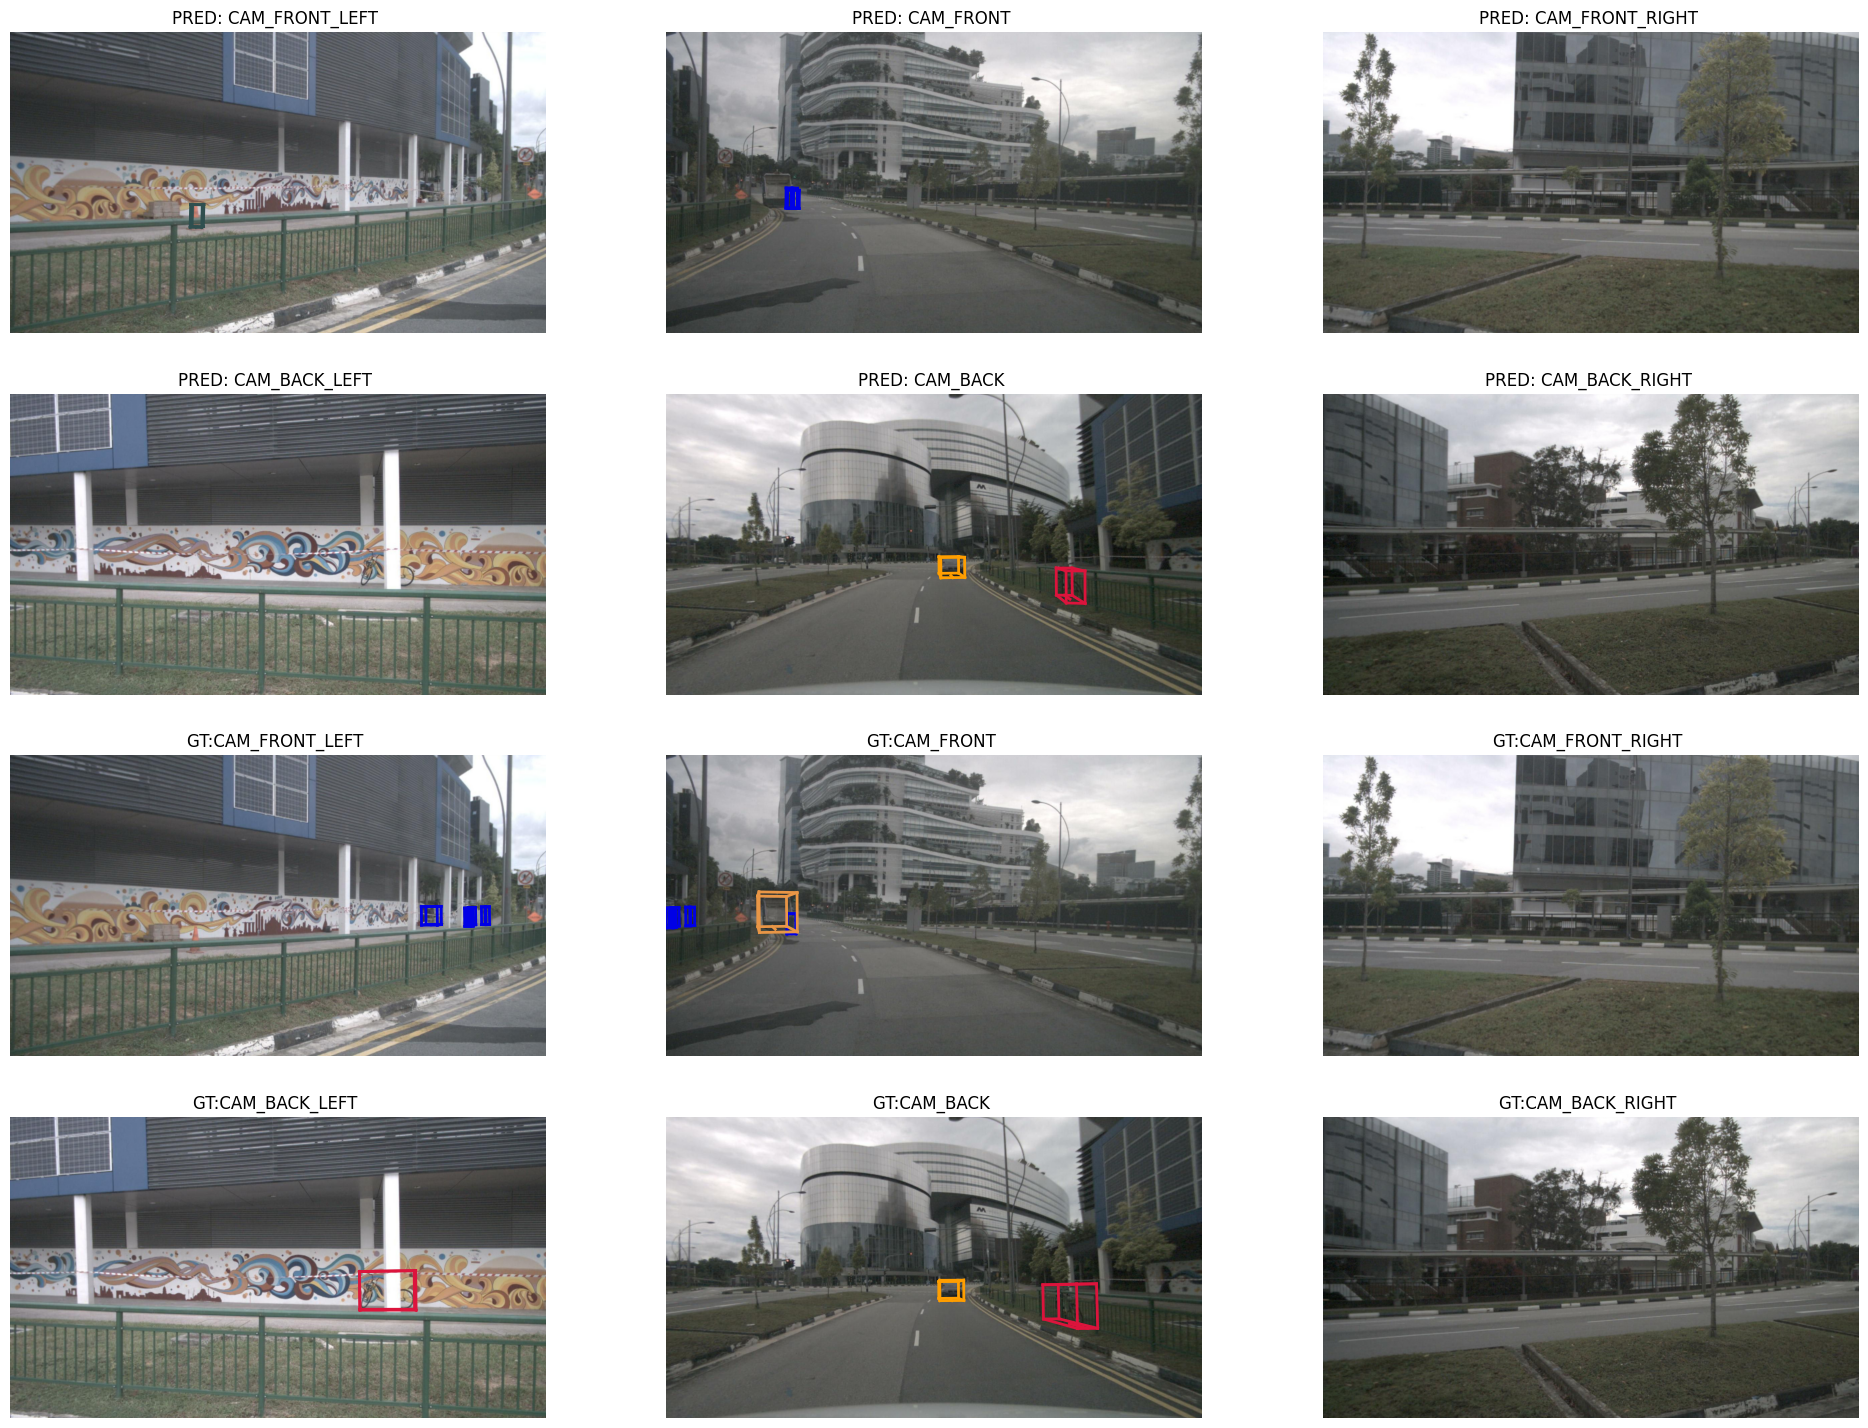

In [ ]:
import os
import copy
import tempfile
import mmcv
import torch

from mmcv.parallel import MMDataParallel
from mmdet.apis import single_gpu_test
from nuscenes.nuscenes import NuScenes

torch.cuda.set_device(0)

# -------------------------
# 1) single GPU test 
# -------------------------
model = MMDataParallel(model.cuda(), device_ids=[0])
outputs = single_gpu_test(model, data_loader, show=False)


full_ds = dataset if "dataset" in globals() else data_loader.dataset
n = len(outputs)

ds20 = copy.copy(full_ds)
assert hasattr(ds20, "data_infos"), "dataset에 data_infos가 없어서 이 방법을 못 써요."
ds20.data_infos = ds20.data_infos[:n]


if hasattr(ds20, "flag") and ds20.flag is not None:
    ds20.flag = ds20.flag[:n]

tmpdir = tempfile.mkdtemp(prefix="bev_vis_")
json_prefix = os.path.join(tmpdir, "nusc_results")

result_files = ds20.format_results(outputs, jsonfile_prefix=json_prefix)


if isinstance(result_files, tuple):
    result_files = result_files[0]

json_path = None
if isinstance(result_files, dict):
    for k in ["pts_bbox", "img_bbox", "bbox", "results"]:
        if k in result_files:
            json_path = result_files[k]
            break
elif isinstance(result_files, str):
    json_path = result_files

if json_path is None:
    raise RuntimeError(f"Unexpected format_results return: {type(result_files)} -> {result_files}")

pred_data = mmcv.load(json_path)
print("json saved at:", json_path)
print("num samples in pred_data:", len(pred_data["results"]))

# -------------------------
# Visualization
# -------------------------
nusc = NuScenes(version="v1.0-trainval", dataroot="./data/nuscenes", verbose=False)

sample_token_list = list(pred_data["results"].keys())
save_prefix = os.path.join(tempfile.mkdtemp(prefix="bev_vis_"), sample_token_list[0])

render_sample_data(
    sample_token_list[0],
    pred_data=pred_data,
    out_path=save_prefix,
    verbose=True
)
